# Detection of Depression in Patients based on Happy, Sad and Fear Emotions

## Installing and Importing the required libraries

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.3 MB/s eta 0:00:00


In [ ]:
import os
from os import listdir
from os.path import isfile, join

#Visualization and data manipulation libraries
import matplotlib.pyplot as plt
import scipy.io
from scipy.signal import butter, lfilter
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=1.2)

#Model development and understanding
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import shap

import tensorflow as tf
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation
from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
#from keras_contrib.layers import CRF

In [ ]:
!pip install openpyxl

## Importing the Dataset and Demographic Dataset

In [ ]:
#Import ERP dataframe
df_erp = pd.read_csv('128Channels_ERP_Modma_Summary.csv')

#Import demographics table
df_demog = pd.read_excel('subjects_information_EEG_128channels_ERP_lanzhou_2015.xlsx')

In [ ]:
df_erp['patient_identifier']= [i[:8] for i in df_erp['patient_identifier']]
df_erp['patient_identifier'] = df_erp['patient_identifier'].astype(int)

In [ ]:
df = pd.merge(df_erp,df_demog,left_on = 'patient_identifier',right_on = 'subject id',how ='inner')
#Set Patient Identifier as index and delete some columns
df.set_index('patient_identifier',inplace=True)
df.drop(columns = ['Unnamed: 11', 'Unnamed: 12','subject id'],inplace = True)

In [ ]:
#Explore the dataset
print("# of Patients:"+str(df.shape[0]))
print("******Understading Features******")
print("# of Electrode:16")
print("\n***Linear Features***")
print("# of Linear Features by emotion (Fear, Happy, Sad)\n16 Electrodes*8 features :"+str(len([i for i in df.columns if 'lf' in i and 'fear' in i])))
print("# of Total Linear Features\n16 Electrodes*8 features*3 Emotions:"+str(len([i for i in df.columns if 'lf' in i])))
print("\n***Non Linear Features***")
print("# of Non Features by emotion (Fear, Happy, Sad)\n16 Electrodes*3 features:"+str(len([i for i in df.columns if 'nl' in i and 'fear' in i])))
print("# of Non Linear Features\n:16 Electrodes*3 features*3 Emotions :"+str(len([i for i in df.columns if 'nl' in i])))
print("\n***Rest of the Features***")
print("# of Other Features:"+str(538-len([i for i in df.columns if 'nl' in i or 'lf' in i])))
print("\n***Total Features***")
print("# of Total Features (512+192+10):"+str(df.shape[1]))
df.head()

# of Patients:53
******Understading Features******
# of Electrode:16

***Linear Features***
# of Linear Features by emotion (Fear, Happy, Sad)
16 Electrodes*8 features :128
# of Total Linear Features
16 Electrodes*8 features*3 Emotions:384

***Non Linear Features***
# of Non Features by emotion (Fear, Happy, Sad)
16 Electrodes*3 features:48
# of Non Linear Features
:16 Electrodes*3 features*3 Emotions :144

***Rest of the Features***
# of Other Features:10

***Total Features***
# of Total Features (512+192+10):539


,Unnamed: 0,lf_alpha_fear_E36,lf_beta_fear_E36,lf_delta_fear_E36,lf_theta_fear_E36,lf_mean_fear_E36,lf_max_fear_E36,lf_min_fear_E36,lf_median_fear_E36,lf_alpha_happy_E36,...,type,age,gender,education（years）,PHQ-9,CTQ-SF,LES,SSRS,GAD-7,PSQI
patient_identifier,,,,,,,,,,,,,,,,,,,,,
2010002,0,0.005291,0.002654,0.022247,0.008512,0.080984,704.726631,0.000066,0.002588,0.002488,...,MDD,18,F,12,23,77,-143,31,18,12
2010004,0,0.001547,0.001293,0.006899,0.002262,0.011431,80.818553,0.000009,0.001480,0.001653,...,MDD,25,F,19,12,53,-44,38,13,11
2010005,0,0.001733,0.001230,0.022651,0.004279,0.019925,167.840425,0.000022,0.001339,0.001817,...,MDD,20,M,16,19,49,-3,28,11,5
2010006,0,0.003123,0.001915,0.012892,0.004892,0.036558,302.628925,0.000035,0.002017,0.002628,...,MDD,42,M,16,16,59,-30,40,12,9
2010008,0,0.003473,0.003368,0.015247,0.007565,0.059222,517.229278,0.000041,0.003682,0.002941,...,MDD,42,M,12,17,66,-71,44,18,13


In [ ]:
df = df.drop(columns='Unnamed: 0')
df.head()

,lf_alpha_fear_E36,lf_beta_fear_E36,lf_delta_fear_E36,lf_theta_fear_E36,lf_mean_fear_E36,lf_max_fear_E36,lf_min_fear_E36,lf_median_fear_E36,lf_alpha_happy_E36,lf_beta_happy_E36,...,type,age,gender,education（years）,PHQ-9,CTQ-SF,LES,SSRS,GAD-7,PSQI
patient_identifier,,,,,,,,,,,,,,,,,,,,,
2010002,0.005291,0.002654,0.022247,0.008512,0.080984,704.726631,0.000066,0.002588,0.002488,0.001498,...,MDD,18,F,12,23,77,-143,31,18,12
2010004,0.001547,0.001293,0.006899,0.002262,0.011431,80.818553,0.000009,0.001480,0.001653,0.001095,...,MDD,25,F,19,12,53,-44,38,13,11
2010005,0.001733,0.001230,0.022651,0.004279,0.019925,167.840425,0.000022,0.001339,0.001817,0.001343,...,MDD,20,M,16,19,49,-3,28,11,5
2010006,0.003123,0.001915,0.012892,0.004892,0.036558,302.628925,0.000035,0.002017,0.002628,0.001971,...,MDD,42,M,16,16,59,-30,40,12,9
2010008,0.003473,0.003368,0.015247,0.007565,0.059222,517.229278,0.000041,0.003682,0.002941,0.001625,...,MDD,42,M,12,17,66,-71,44,18,13


## Plotting the Data Demographics

In [ ]:
#Code to build box plots
def box_plot_builder(df,key='age',title_vals = 'Bias in Enrollment'):
  """
  Inputs:
  df - dataframe
  key - On which we need to group by data
  title_vals - Expected title for the chart

  Outputs:
  Box plot
  """
  val = key
  #Build a categorical column as key for the charts
  key = pd.cut(df[key],bins = 5)
  #Let's first find our demographic profile
  temp = df.groupby([key,'type']).count()['lf_beta_fear_E36'].unstack()
  temp.columns = ['Normal','MDD']

  #Preparing data to represent in grouped column chart
  labels = [(round(i.left),round(i.right)) for i in temp.index.categories]
  normal = temp.Normal/np.sum(temp.Normal)
  mdd = temp.MDD/np.sum(temp.MDD)
  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, normal, width, label='HC (29)')
  rects2 = ax.bar(x + width/2, mdd, width, label='MDD (24)')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('% of patients')
  ax.set_title(title_vals)
  #ax.set_xticks(x, labels)
  ax.set_xlabel(val)
  ax.set_xticks(x) # values
  ax.set_xticklabels(labels) # labels
  ax.legend()

  #save the charts
  #fig.tight_layout()

  #path_to_save = 'EA_Demog_'+val+'.png'
  #fig.savefig(path_to_save,dpi = 100)

  plt.show()

In [ ]:
df_demog.columns

Index(['subject id', 'type', 'age', 'gender', 'education（years）', 'PHQ-9',
       'CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI', 'Unnamed: 11', 'Unnamed: 12'],
      dtype='object')

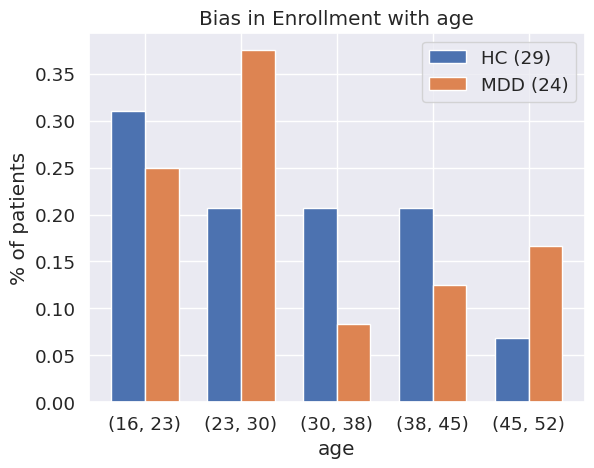

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


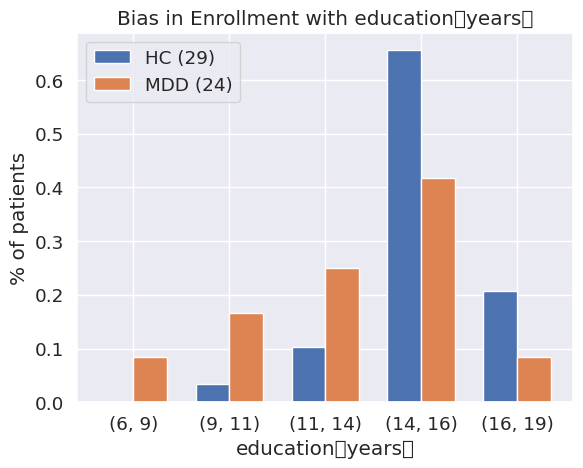

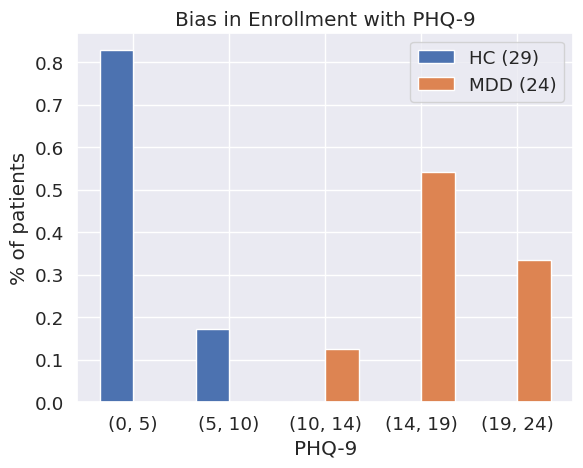

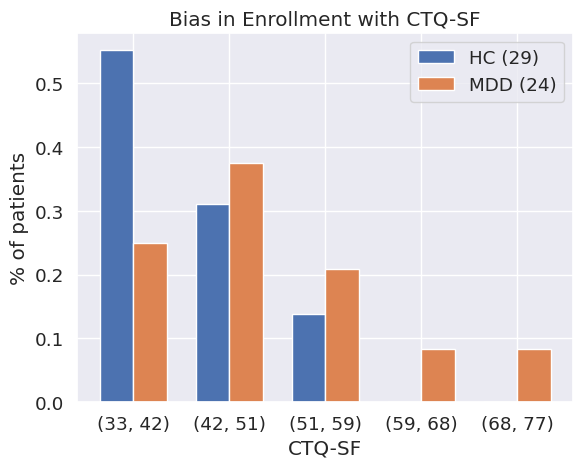

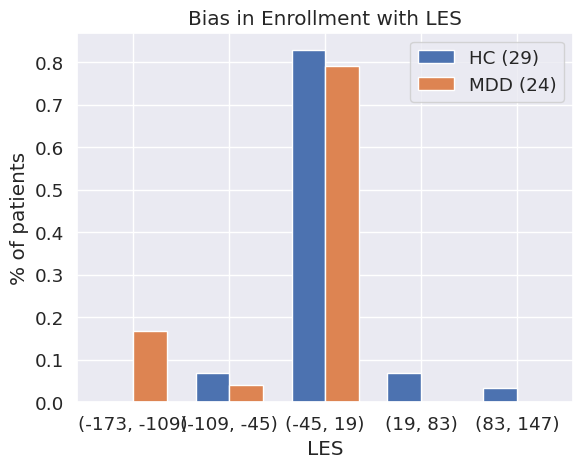

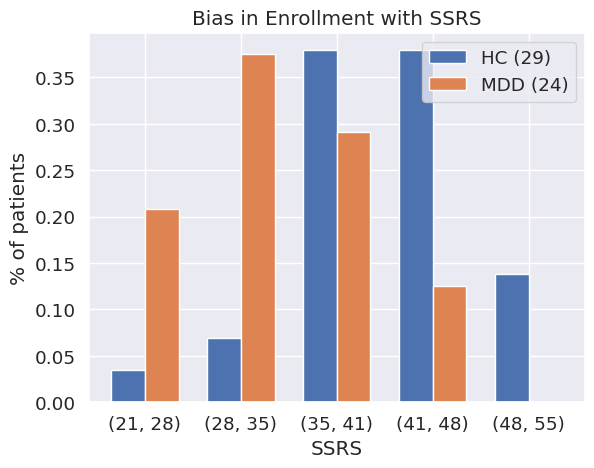

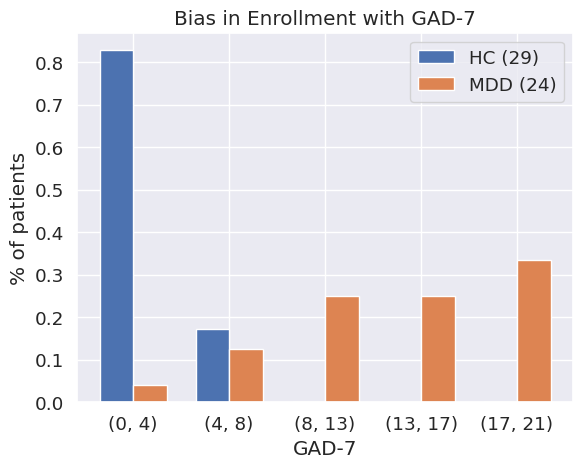

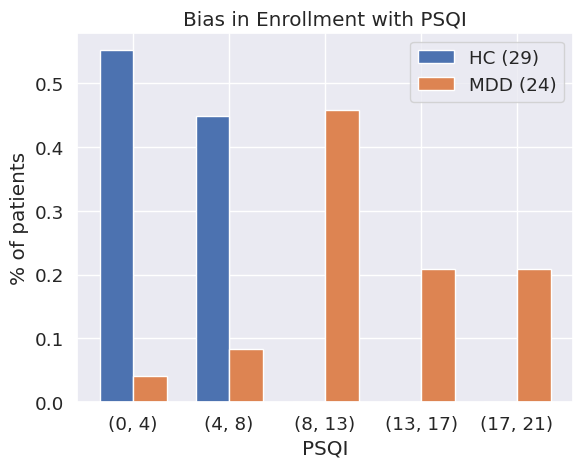

In [ ]:
for cols in ['age','education（years）', 'PHQ-9','CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI']:
  box_plot_builder(df,key=cols,title_vals = 'Bias in Enrollment with '+cols)

In [ ]:
df.drop(columns=['age','gender','education（years）', 'PHQ-9','CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI'], inplace=True)
#df

## Extraction of Columns and Feature Analysis

In [ ]:
def columns_extractor(df,emotion,feature_type,name):
  """
  Inputs:
  df - Dataframe that we are using
  emotion - There are four emotions namely : Happy, Fear, Sad and Resting
  Feature - Either Linear feature (lf) or Non-linear features (nl)
  Outputs:
  resultant data frame
  """
  if feature_type =='lf':
    columns_to_extract = [i for i in df.columns if feature_type in i and emotion in i and name in i]
    final_cols = {i:i.replace(feature_type+'_'+name+'_'+emotion+'_', '') for i in columns_to_extract}
  else:
    columns_to_extract = [i for i in df.columns if feature_type in i and name in i and emotion in i]
    final_cols = {i:i.replace(feature_type+'_'+name+emotion+'_', '') for i in columns_to_extract}
  columns_to_extract.extend(['type'])
  #print(columns_to_extract)
  df_result = df[columns_to_extract]
  return df_result.rename(columns = final_cols)

def correlation_builder(df,prefix):
  """
  Inputs:
  df - Dataframe to be used
  Outputs:
  chart object - This will be saved for future reference
  """
  #Correlation cross tab
  corr_all = df[[i for i in df.columns if 'type' not in i]].corr()
  corr_md = df[df['type']=='MDD'][[i for i in df.columns if 'type' not in i]].corr()
  corr_hc = df[df['type']=='HC'][[i for i in df.columns if 'type' not in i]].corr()
  list_corr = [corr_all,corr_md,corr_hc]
  titles = ['All Participants','MDD','HC']
  #Mask for the upper triangle of correlation to be masked
  mask = np.zeros_like(corr_all)
  mask[np.triu_indices_from(mask)] = True
  min = -1
  max = 1
  a = dict()
  fig =  plt.figure(figsize=(30,12))
  for val in range(3):
    with sns.axes_style("white"):
      a[val] = fig.add_subplot(1,3,val+1)
      a[val] = sns.heatmap(list_corr[val], mask=mask, square=True,vmin=min,vmax=max,cmap = sns.cm.rocket_r,
                           cbar_kws = dict(use_gridspec=False,location="bottom"))
      a[val].set_title(titles[val],fontdict={'fontsize': '20', 'fontweight' : '5'})

  #sns.heatmap(arr, ax=ax, cbar_ax = cbar_ax, cbar=True)
  fig.suptitle('Heat Map for '+prefix, fontsize=30)
  path_to_save = 'EA_'+prefix+'.png'
  #fig.savefig(path_to_save,dpi = 100)
  return corr_all,fig

def column_eliminator(df,thr=0.9):
  columns = np.full((df.shape[0],), True, dtype=bool)
  for i in range(df.shape[0]):
      for j in range(i+1, df.shape[0]):
          if df.iloc[i,j] >= thr:
              if columns[j]:
                  columns[j] = False
  return columns

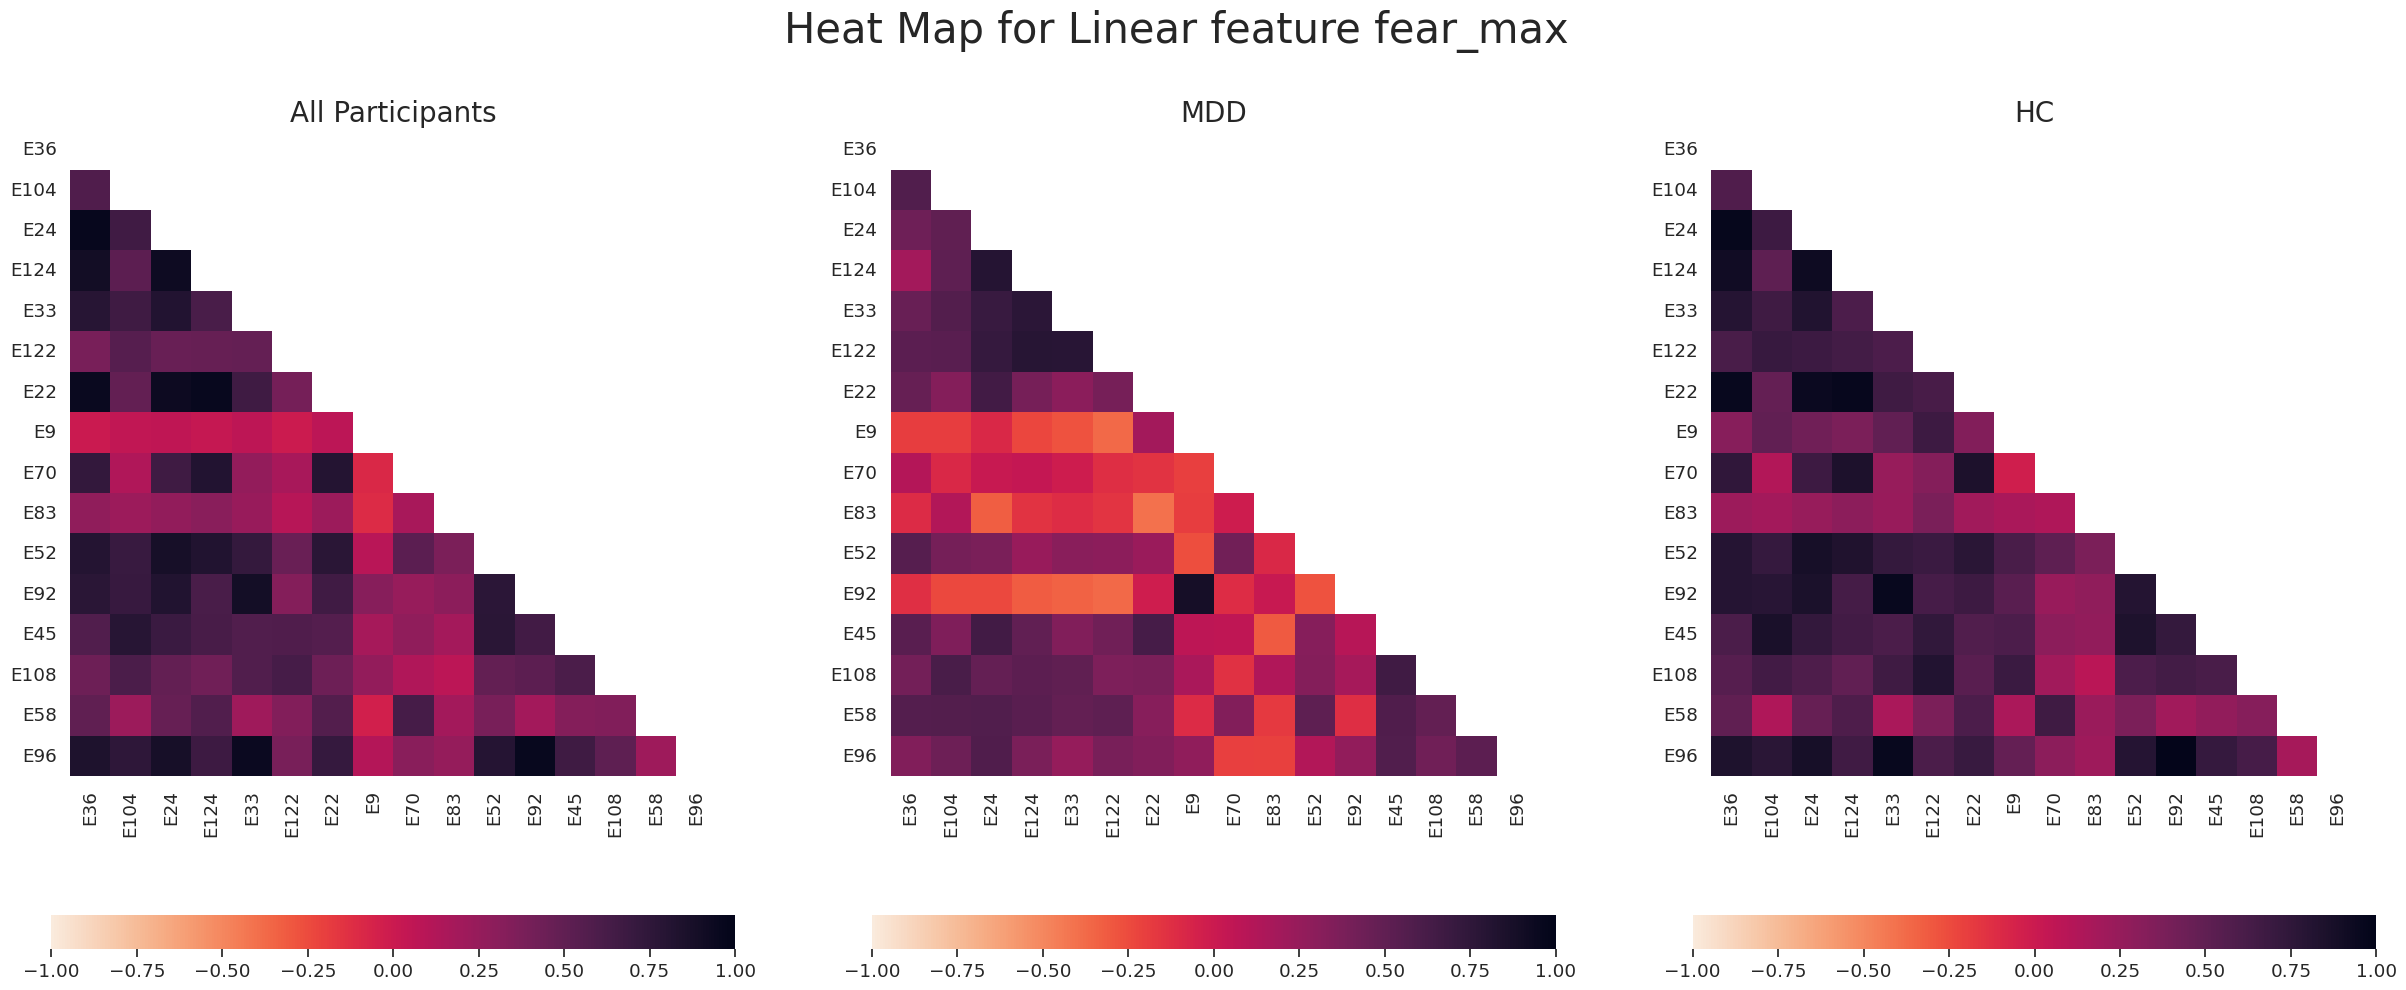

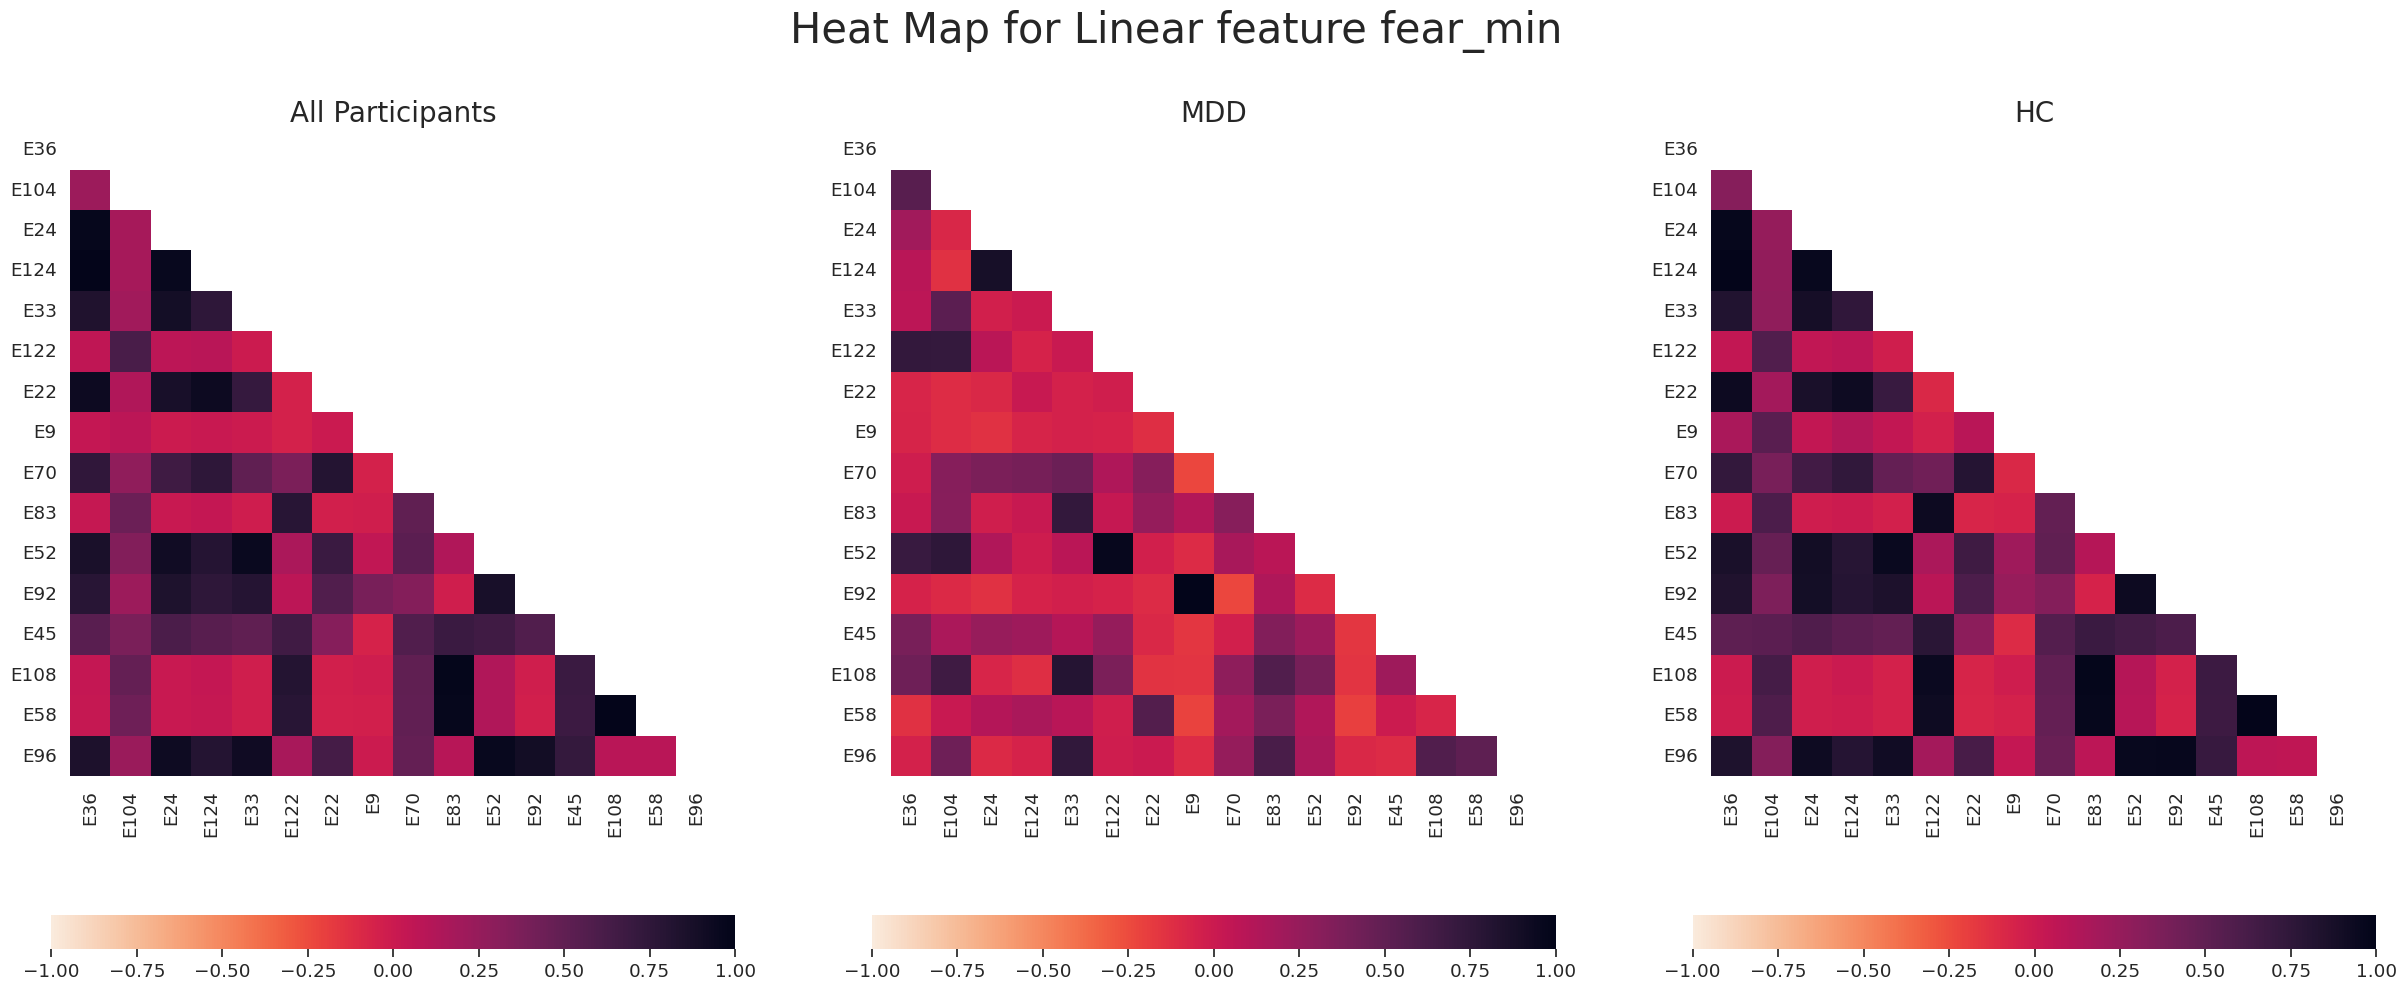

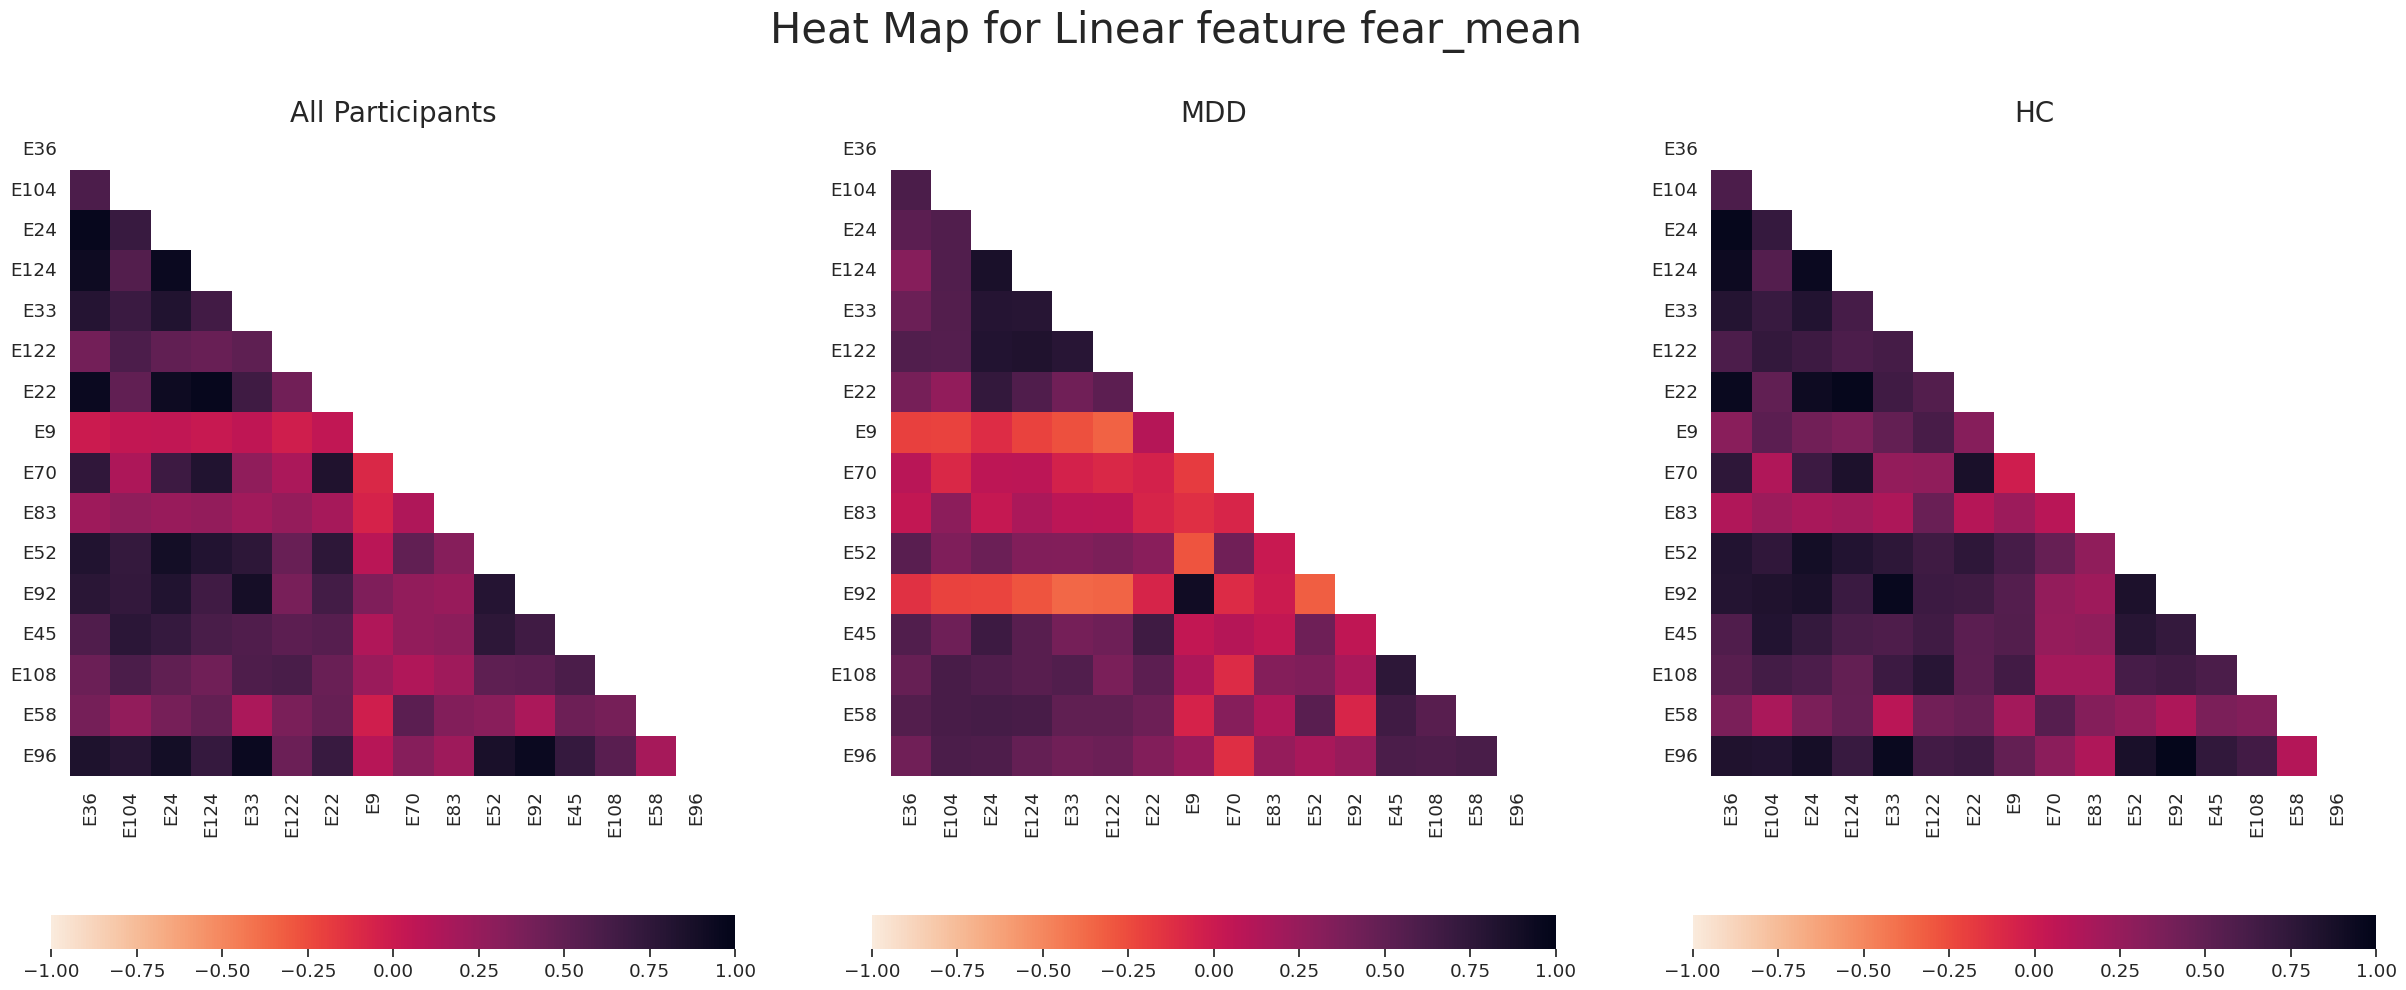

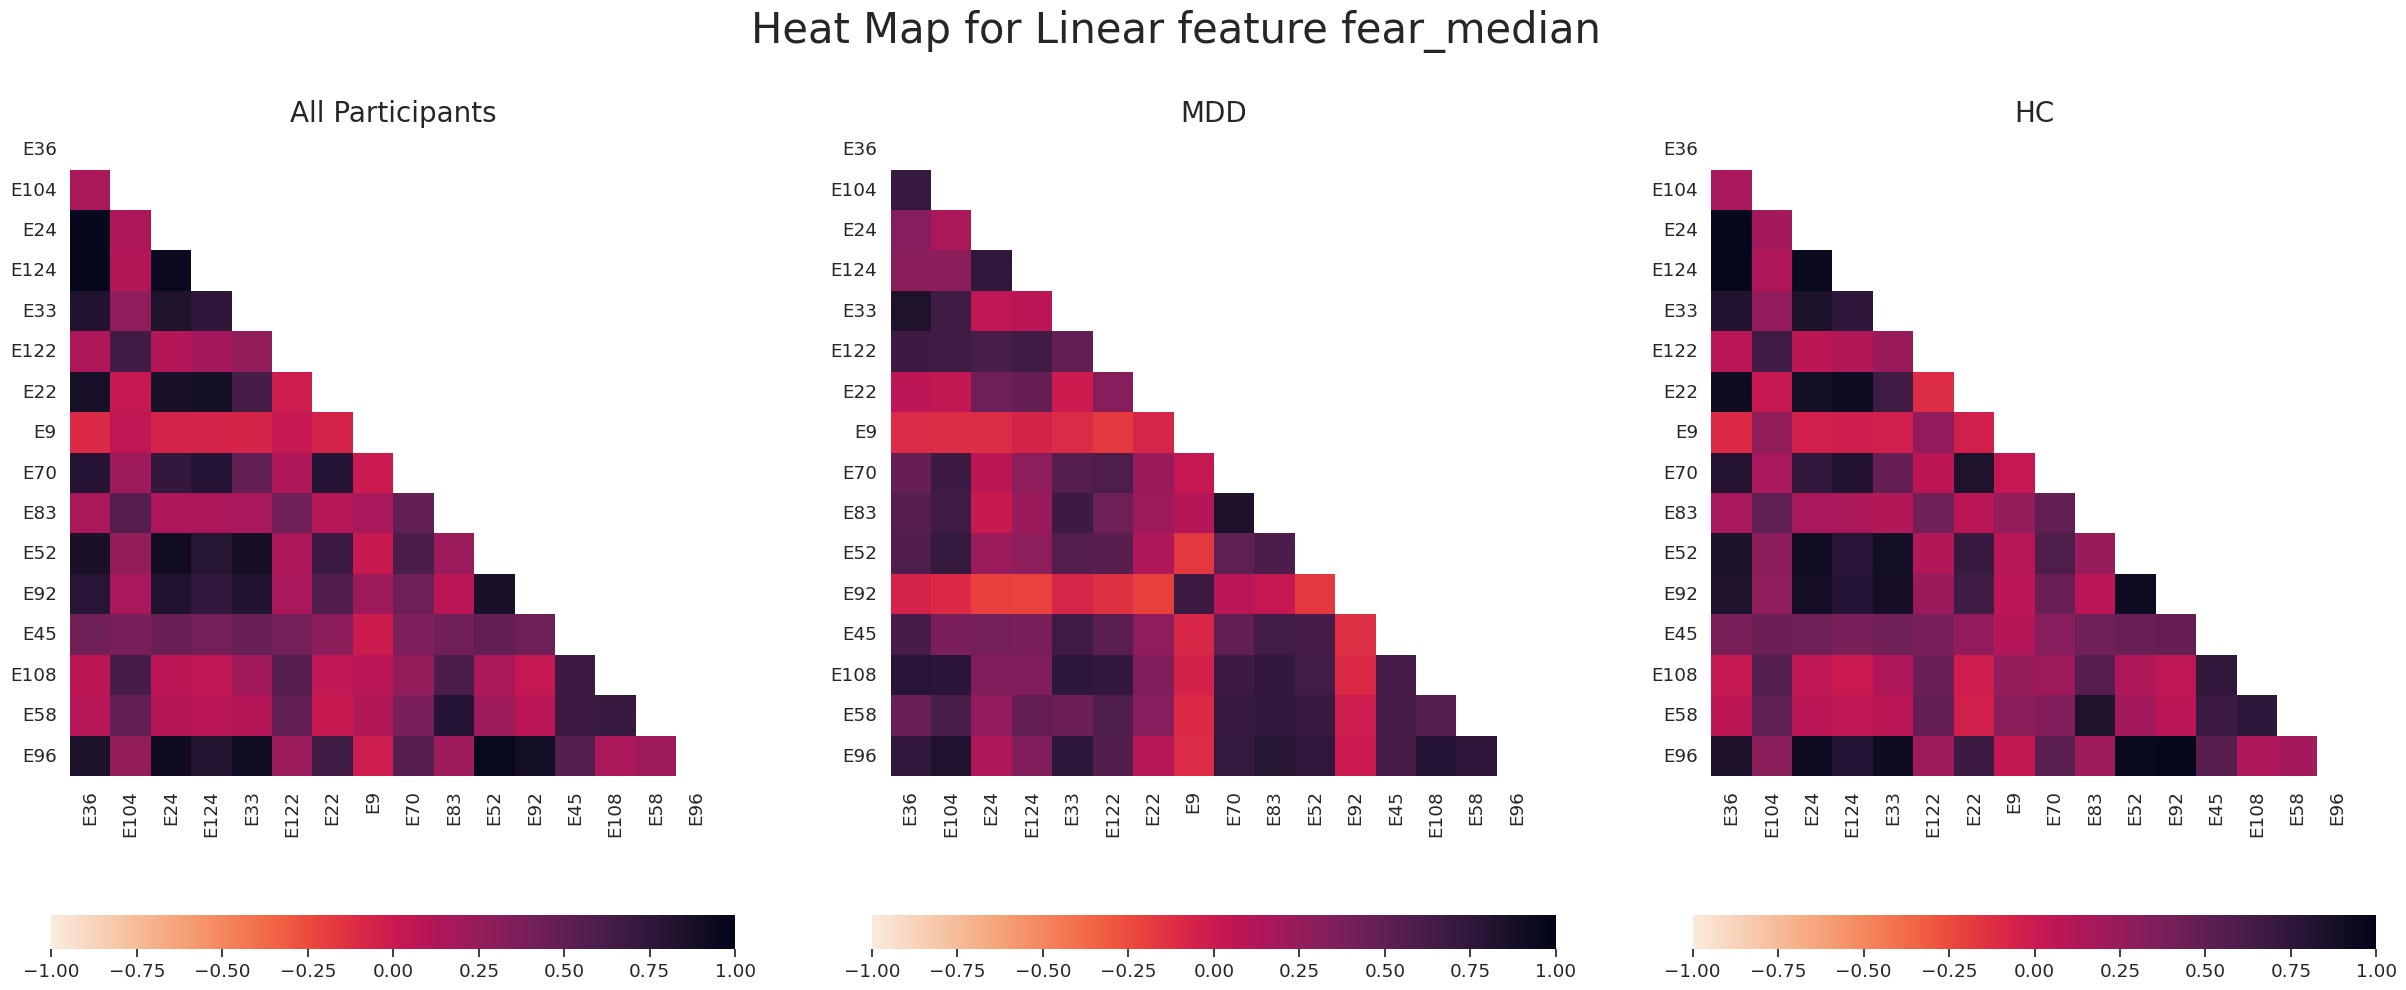

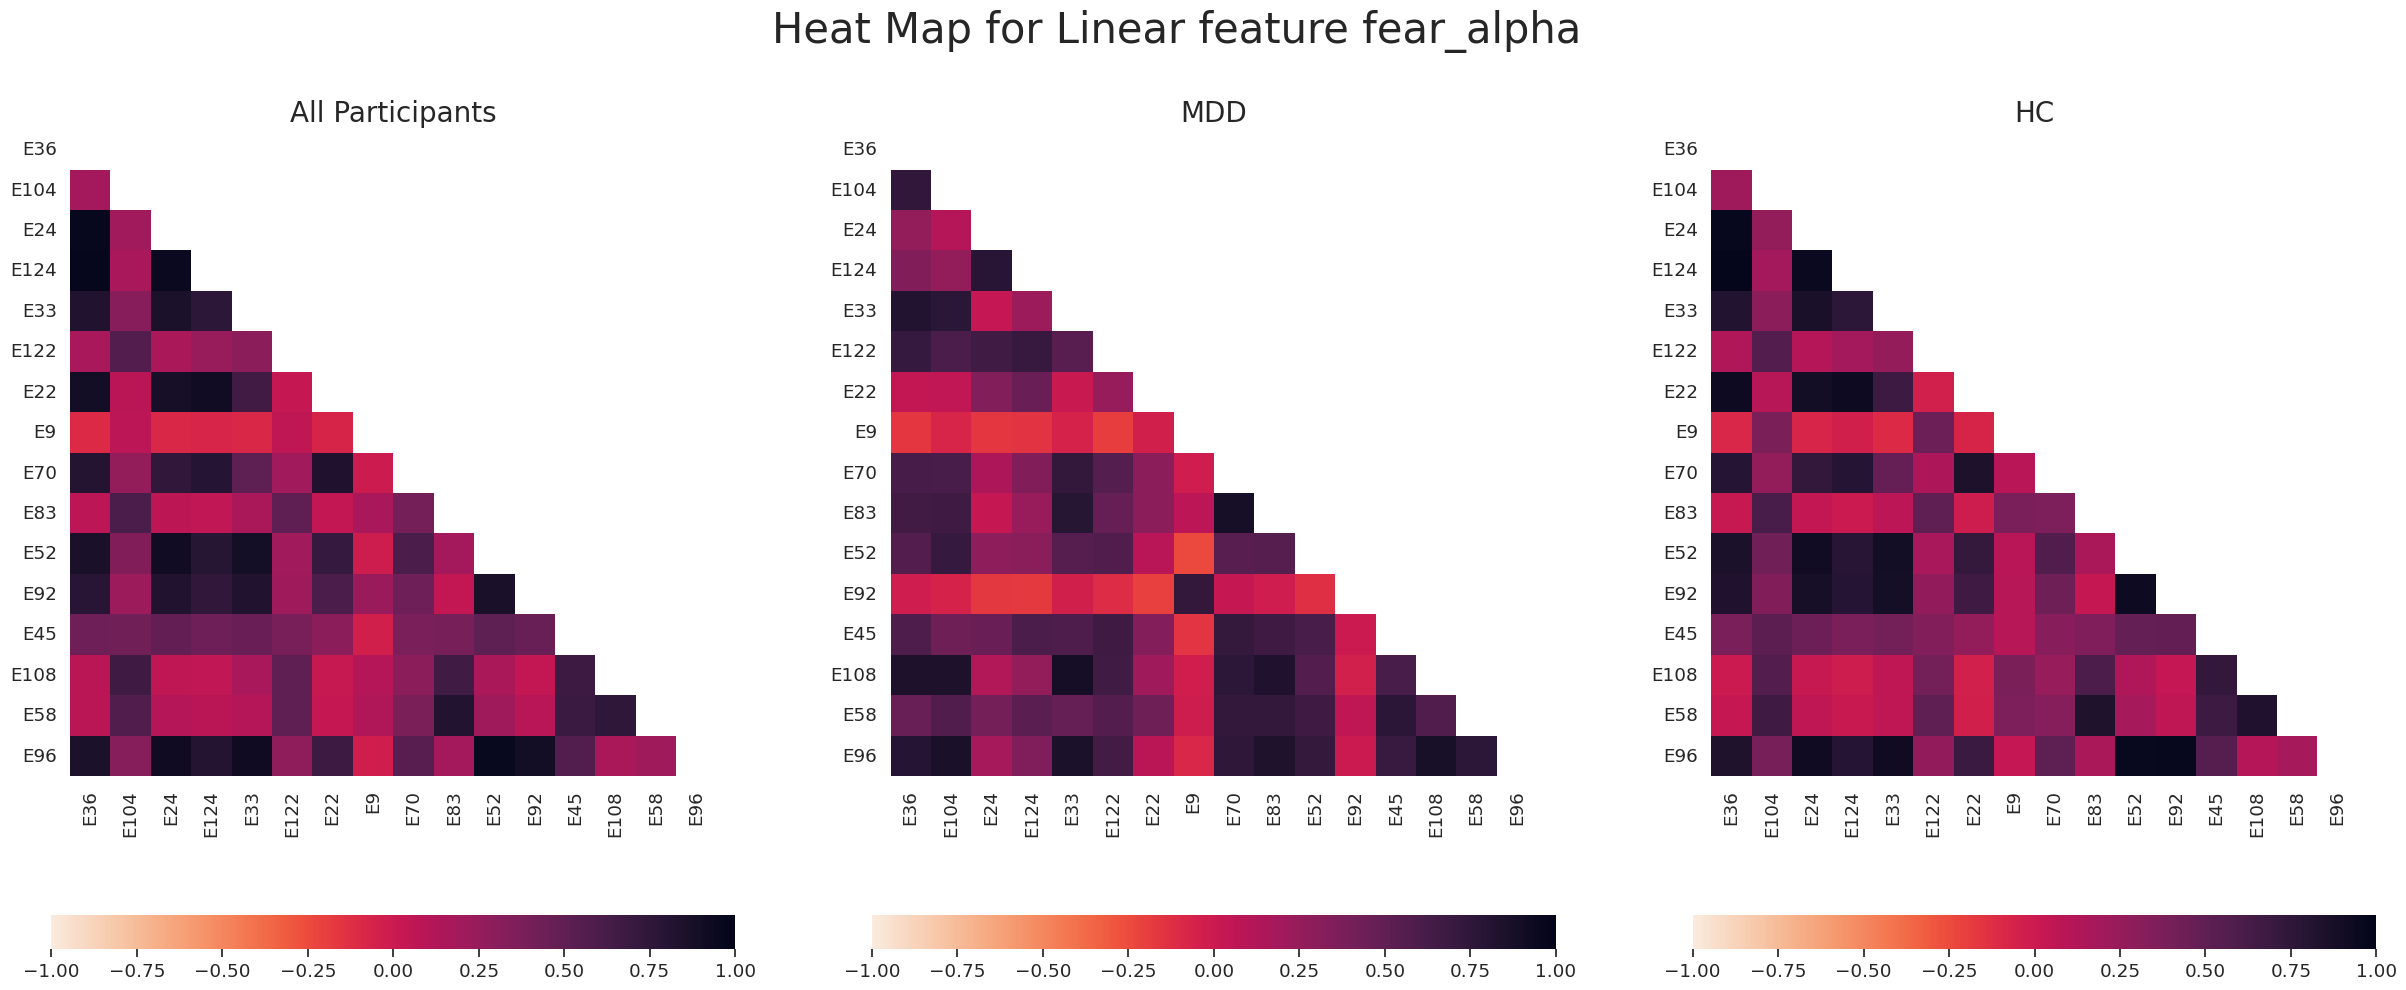

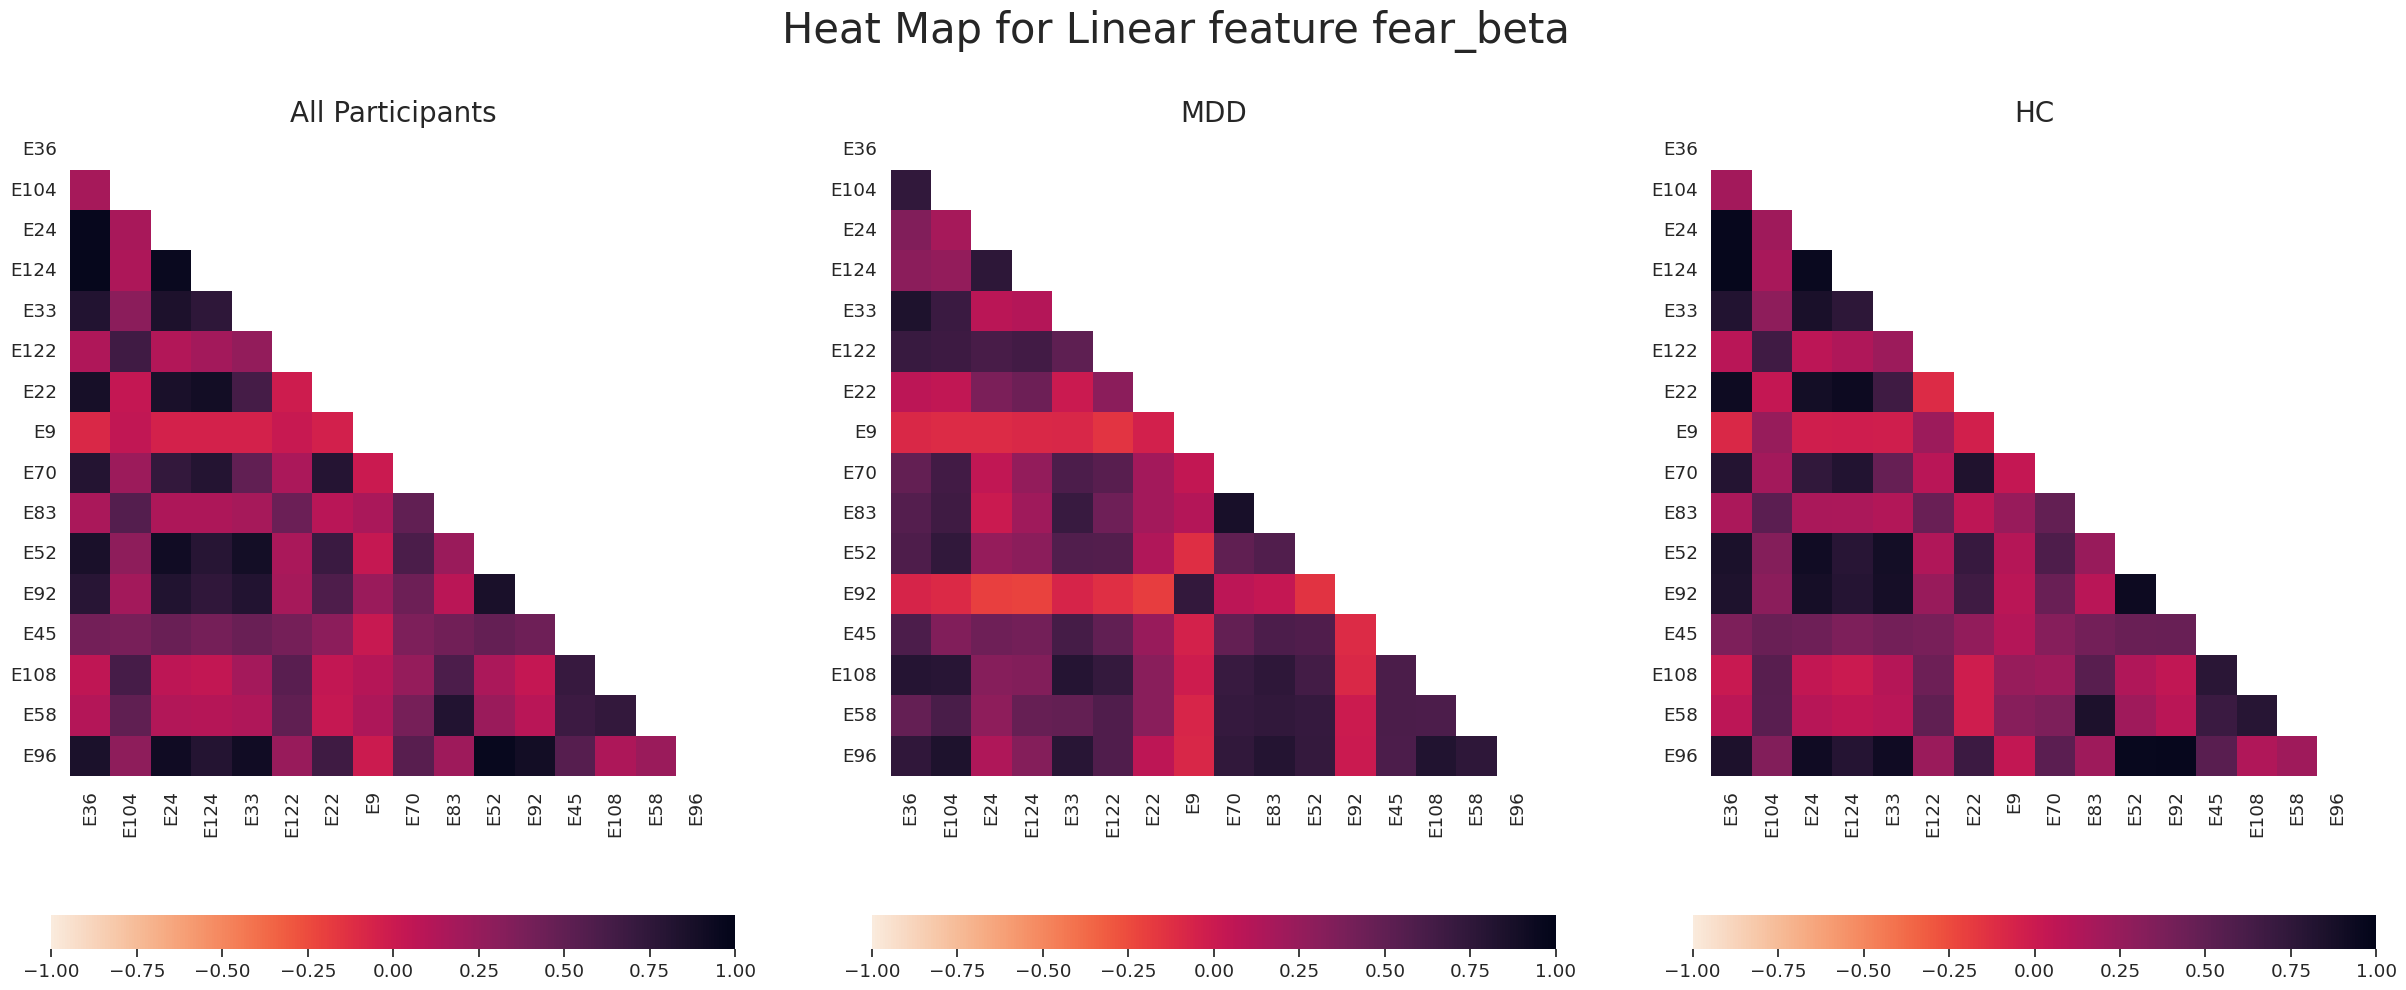

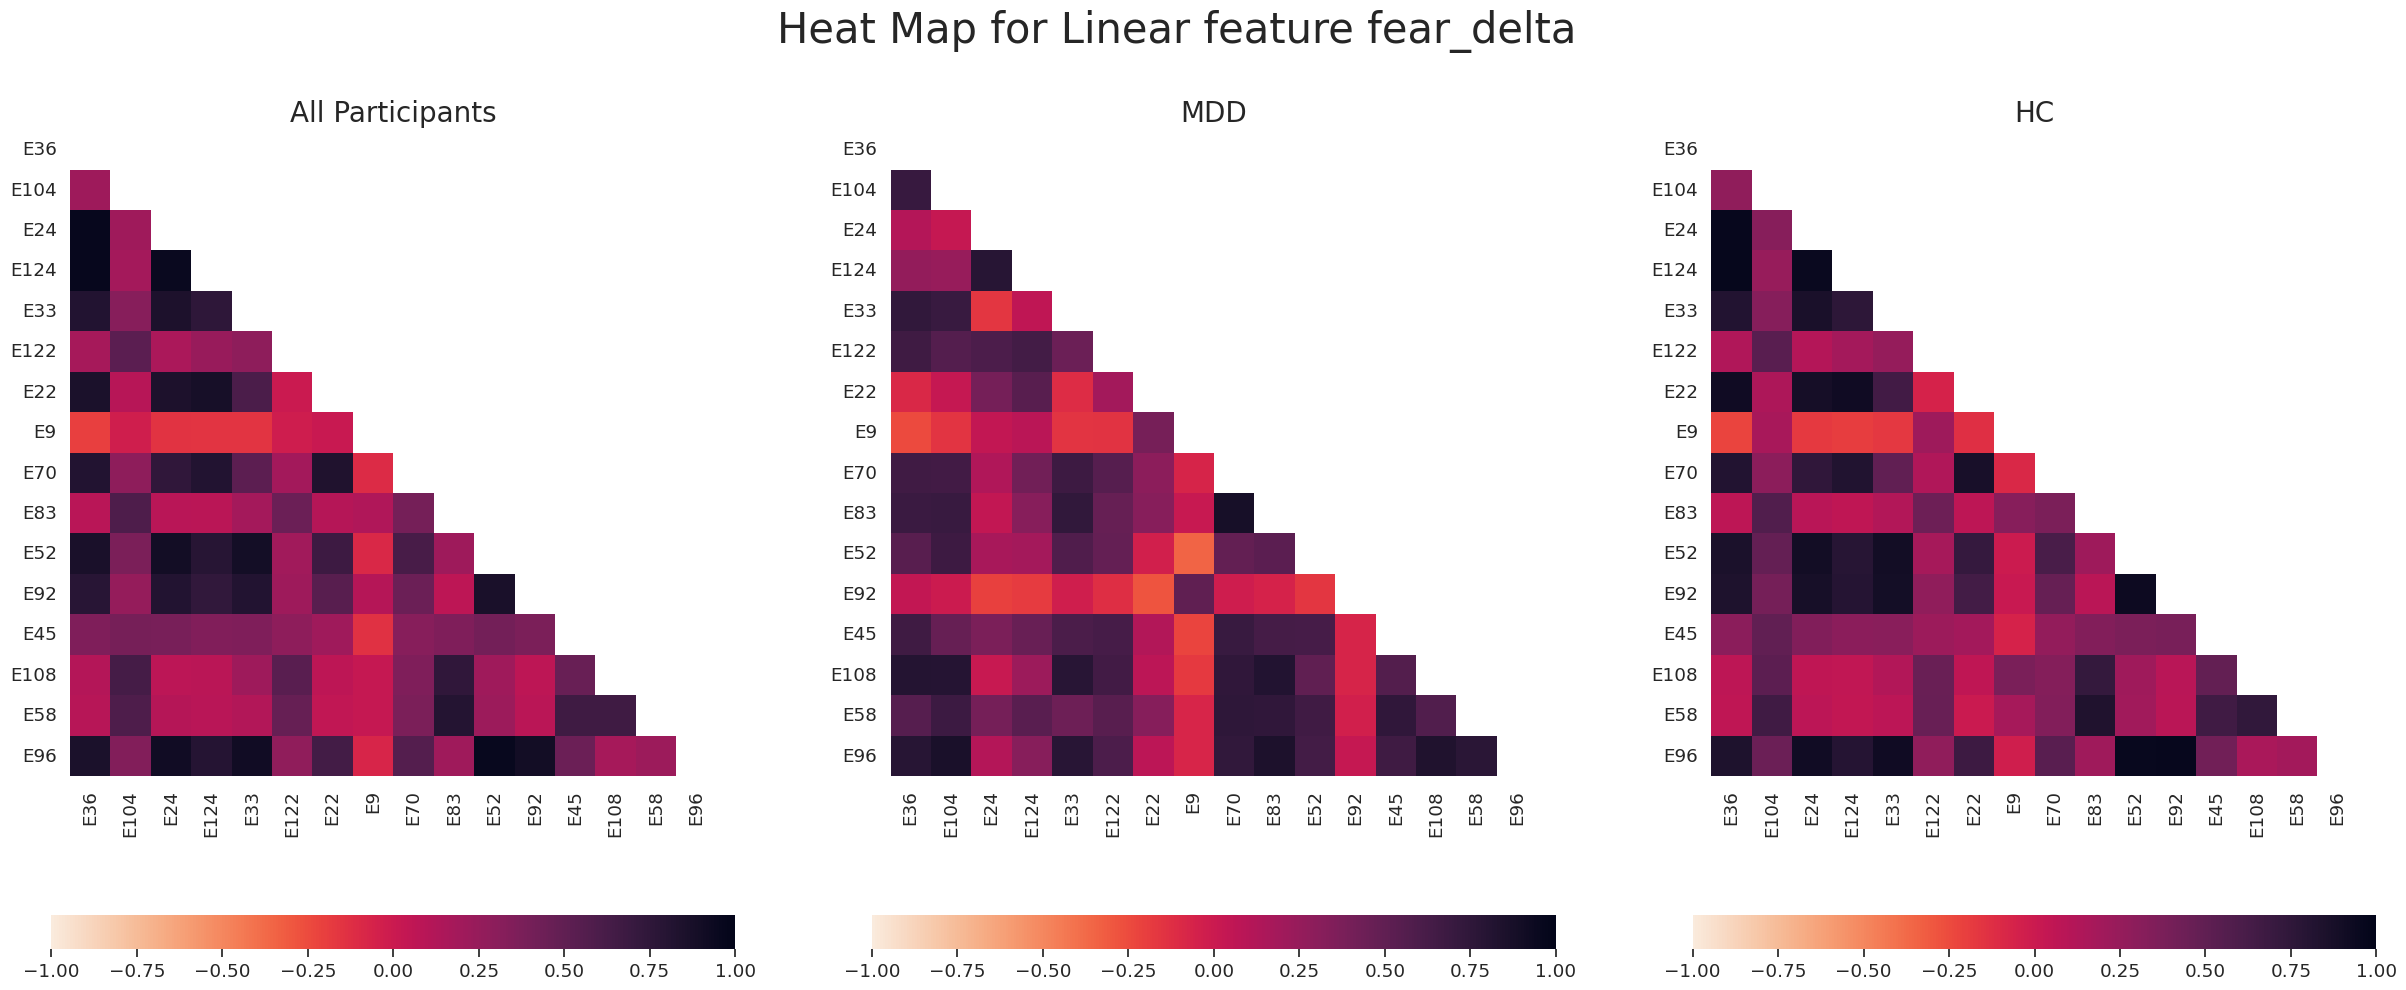

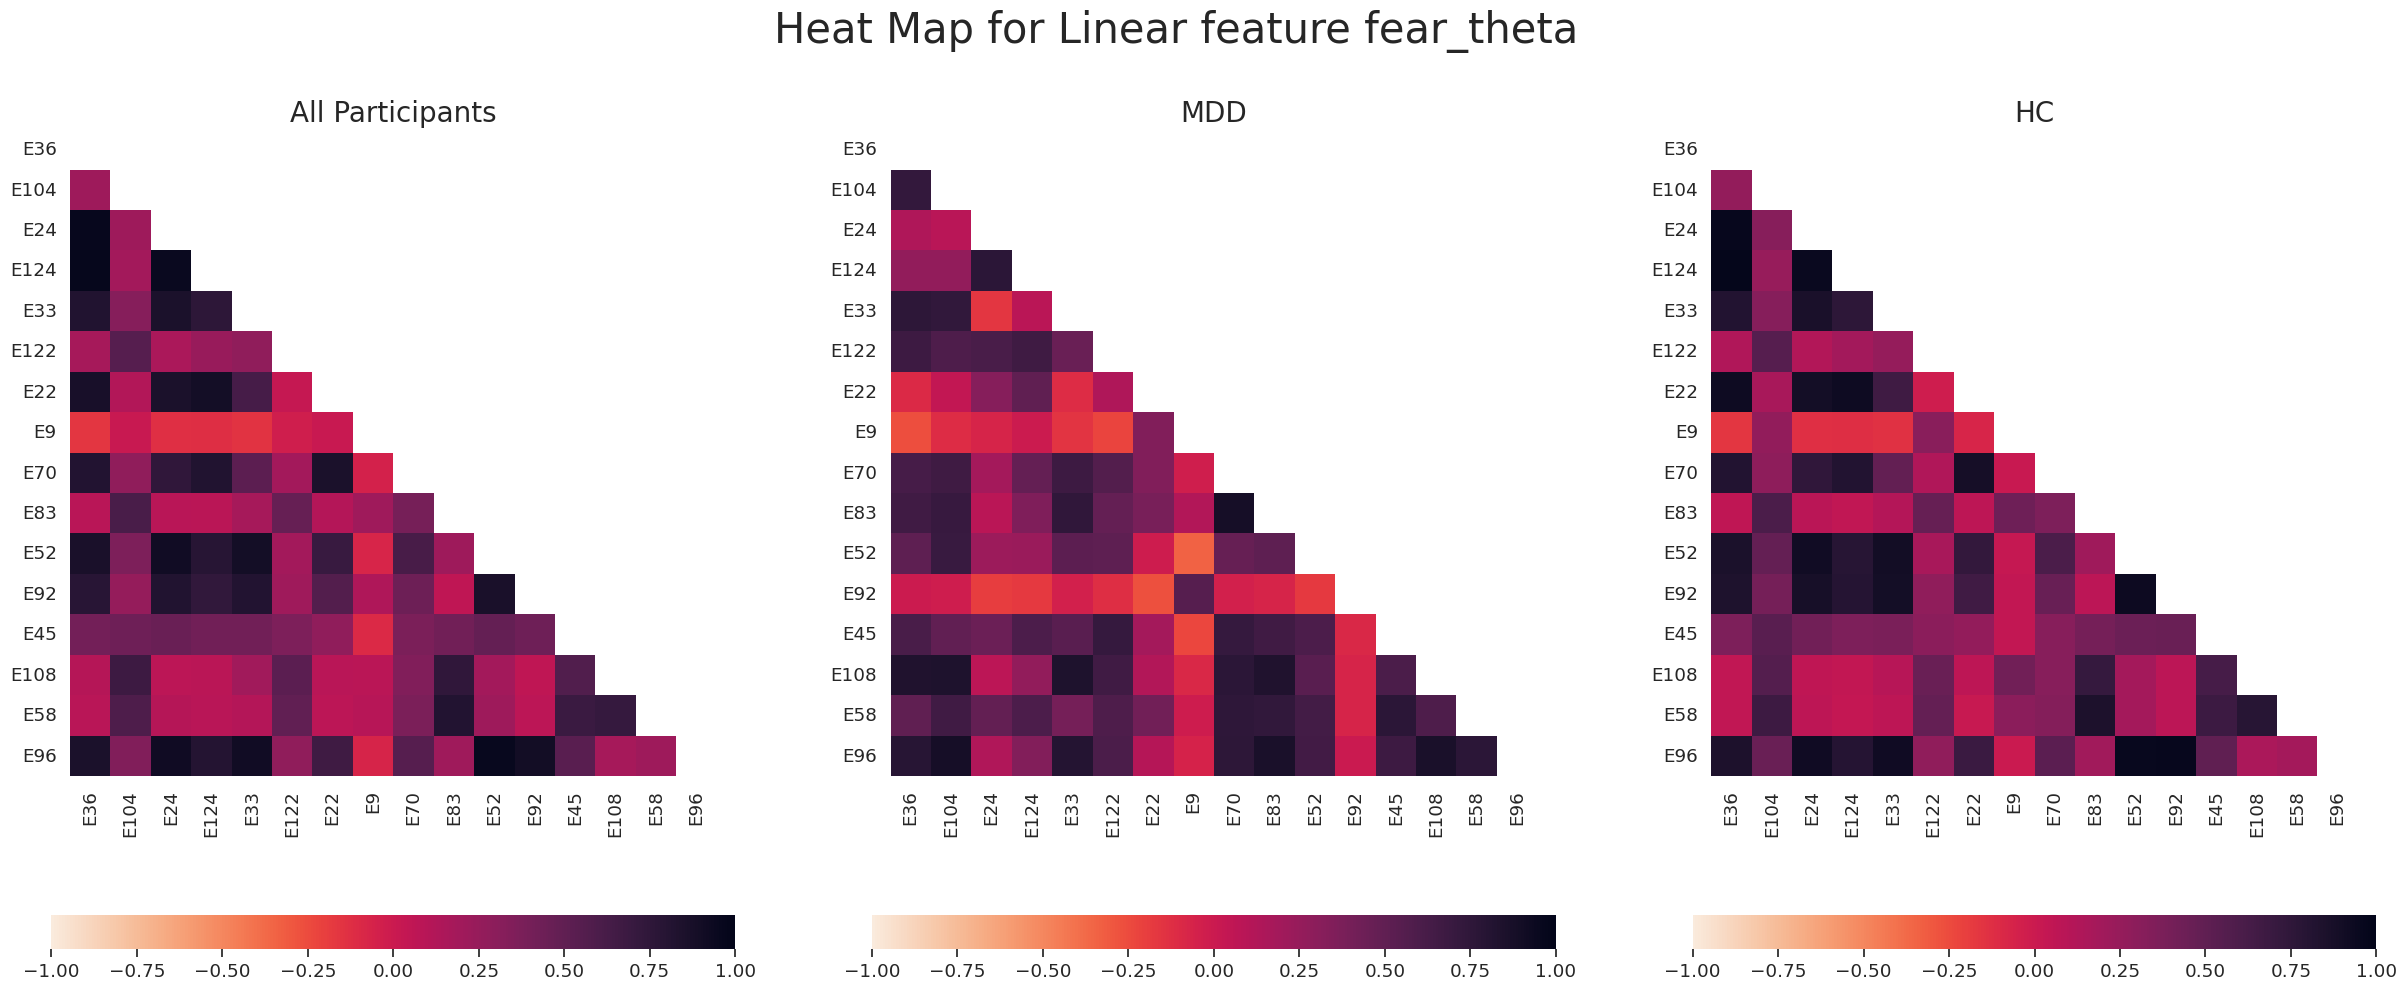

In [ ]:
emotion = 'fear'
for name in ['max','min','mean','median','alpha','beta','delta','theta']:
  temp = columns_extractor(df,emotion,'lf',name)
  a,b = correlation_builder(temp,prefix = 'Linear feature '+emotion+'_'+name)

## Analysis of Linear Features for all emotions

In [ ]:
columns_to_keep = []
for emotion in ['happy','sad','fear']:
    for name in ['max','min','mean','median','alpha','beta','delta','theta']:
        temp = columns_extractor(df,emotion,'lf',name)
        a,b = correlation_builder(temp,prefix = 'Linear feature '+emotion+'_'+name)
        temp.drop(columns = 'type',inplace=True)
        columns_to_keep.extend(['lf_'+name+'_'+emotion+'_'+i for i in temp.columns[column_eliminator(a,thr = 0.8)]])

Output hidden; open in https://colab.research.google.com to view.

It can be seen from the correlation tables that there is a high correlation for a lot of the features, however there are some interesting results with varying correlation for electrodes E9 to E92. This can especially be seen for the linear features for the sad emotion, especially for MDD Patients

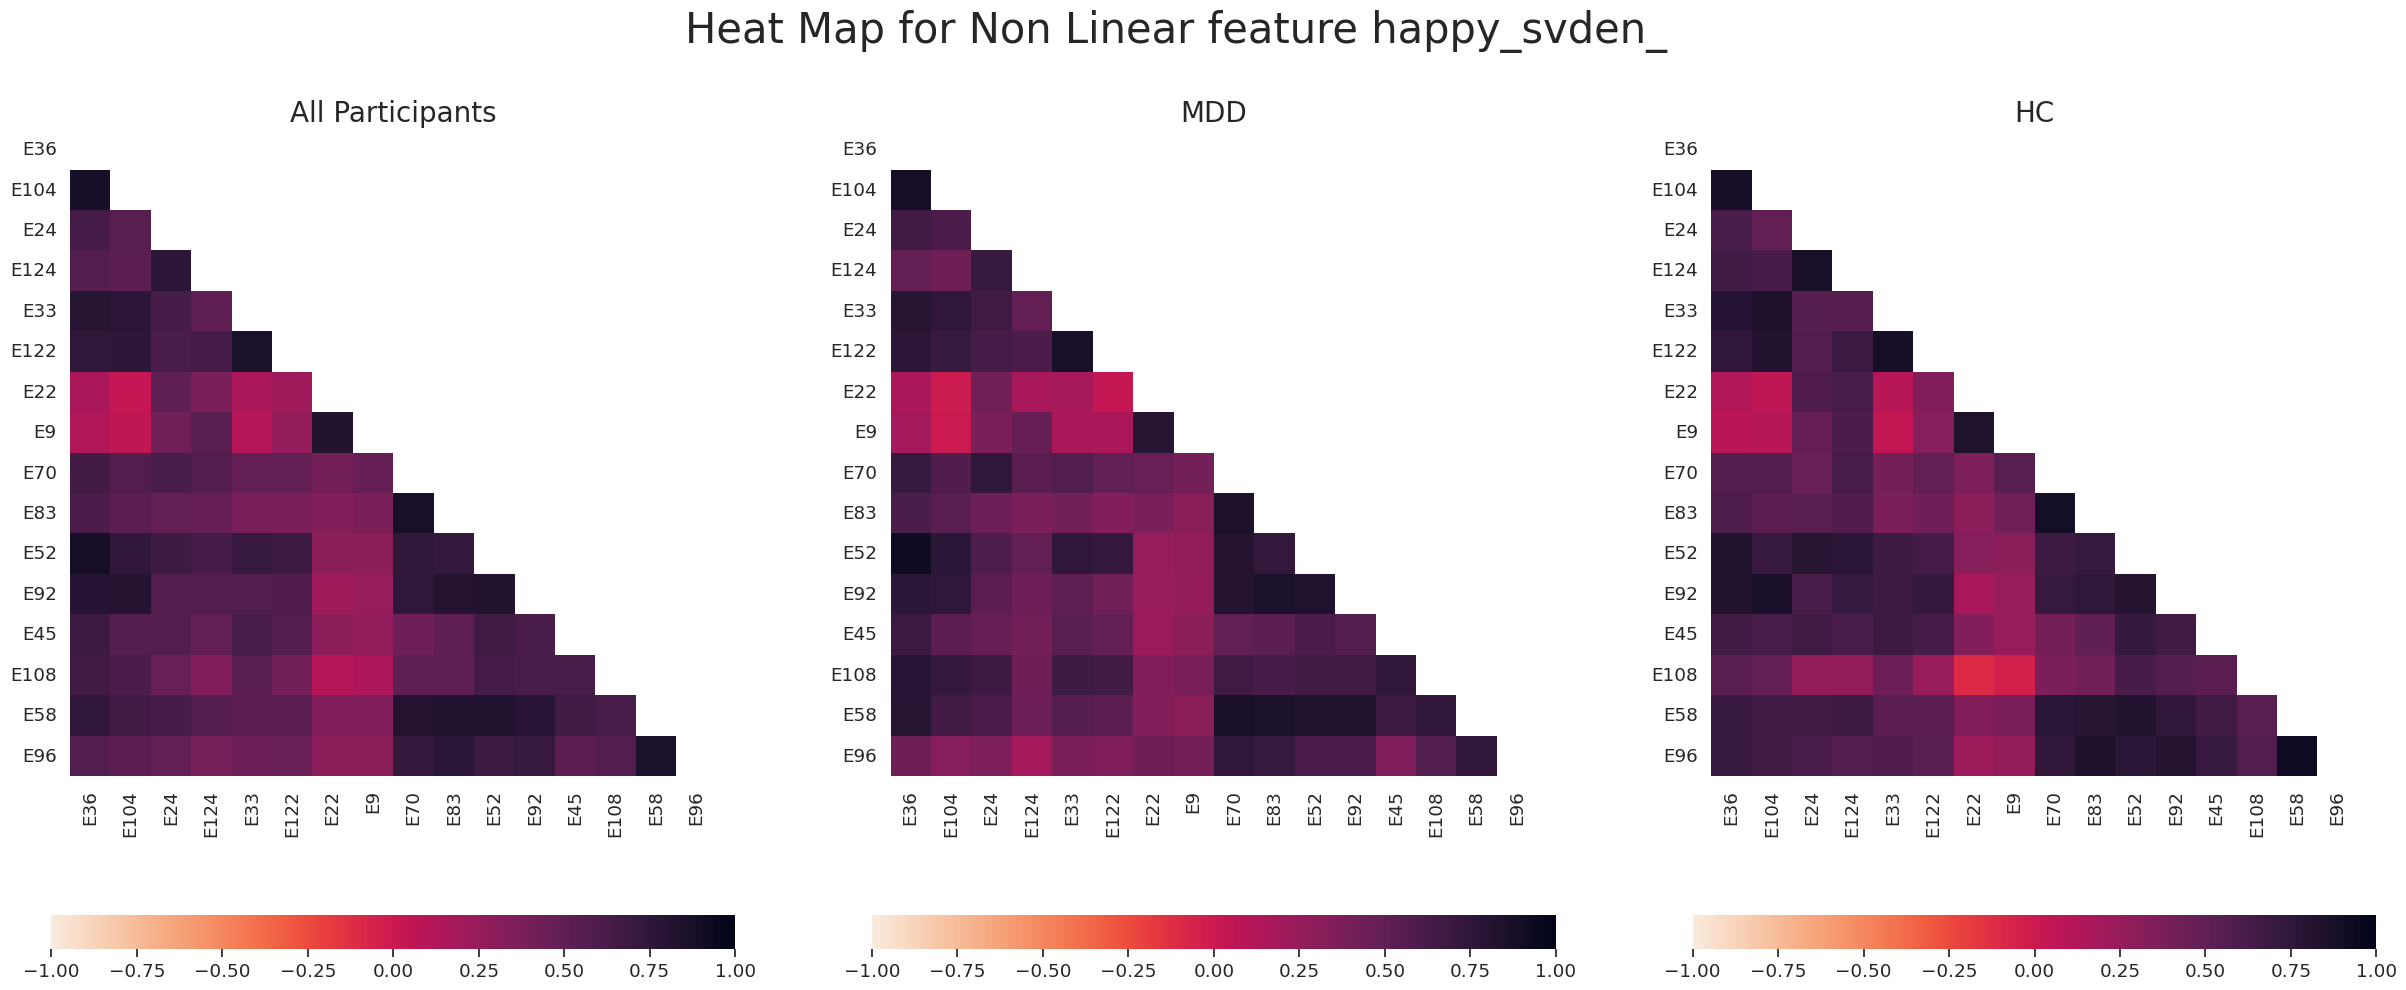

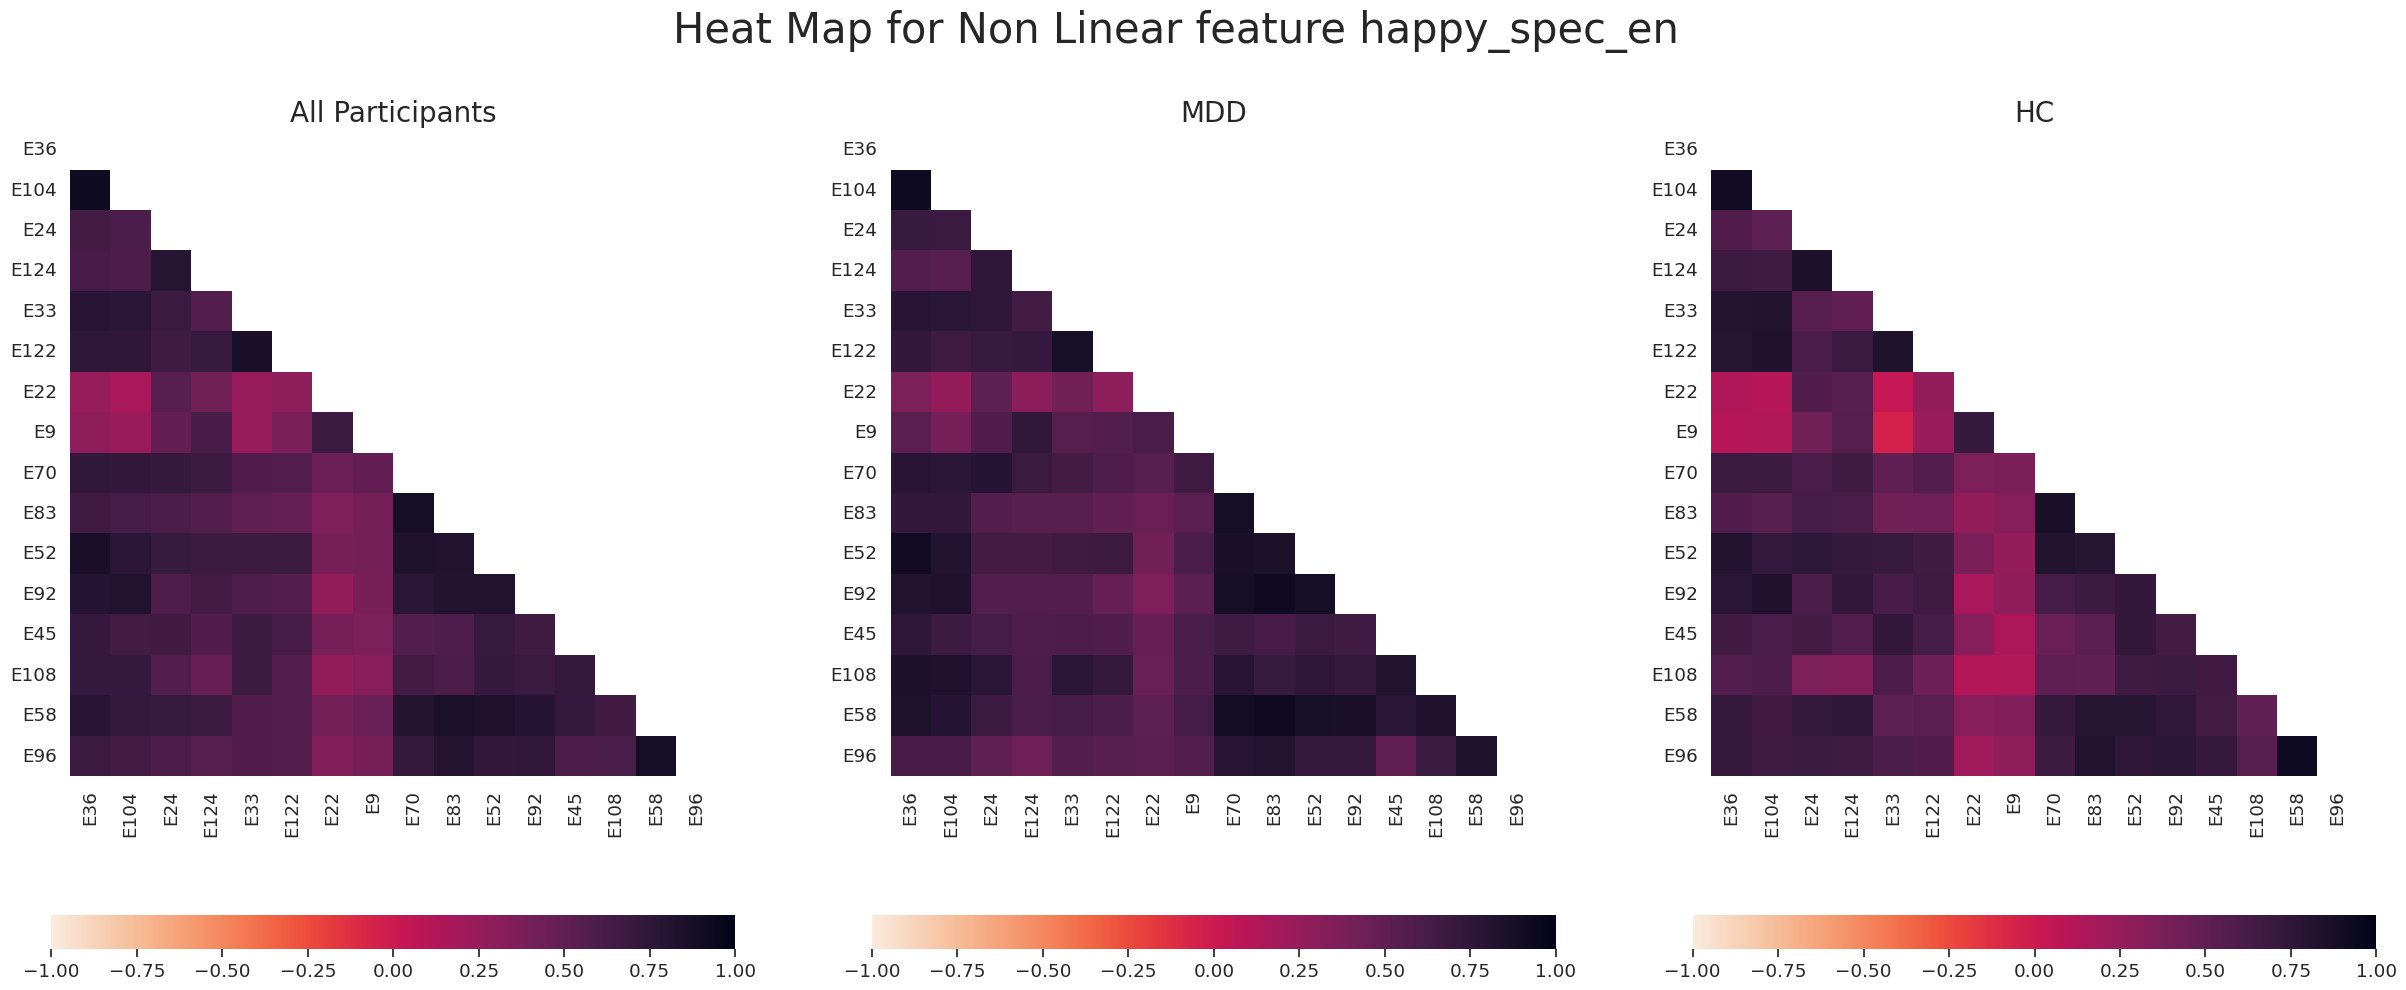

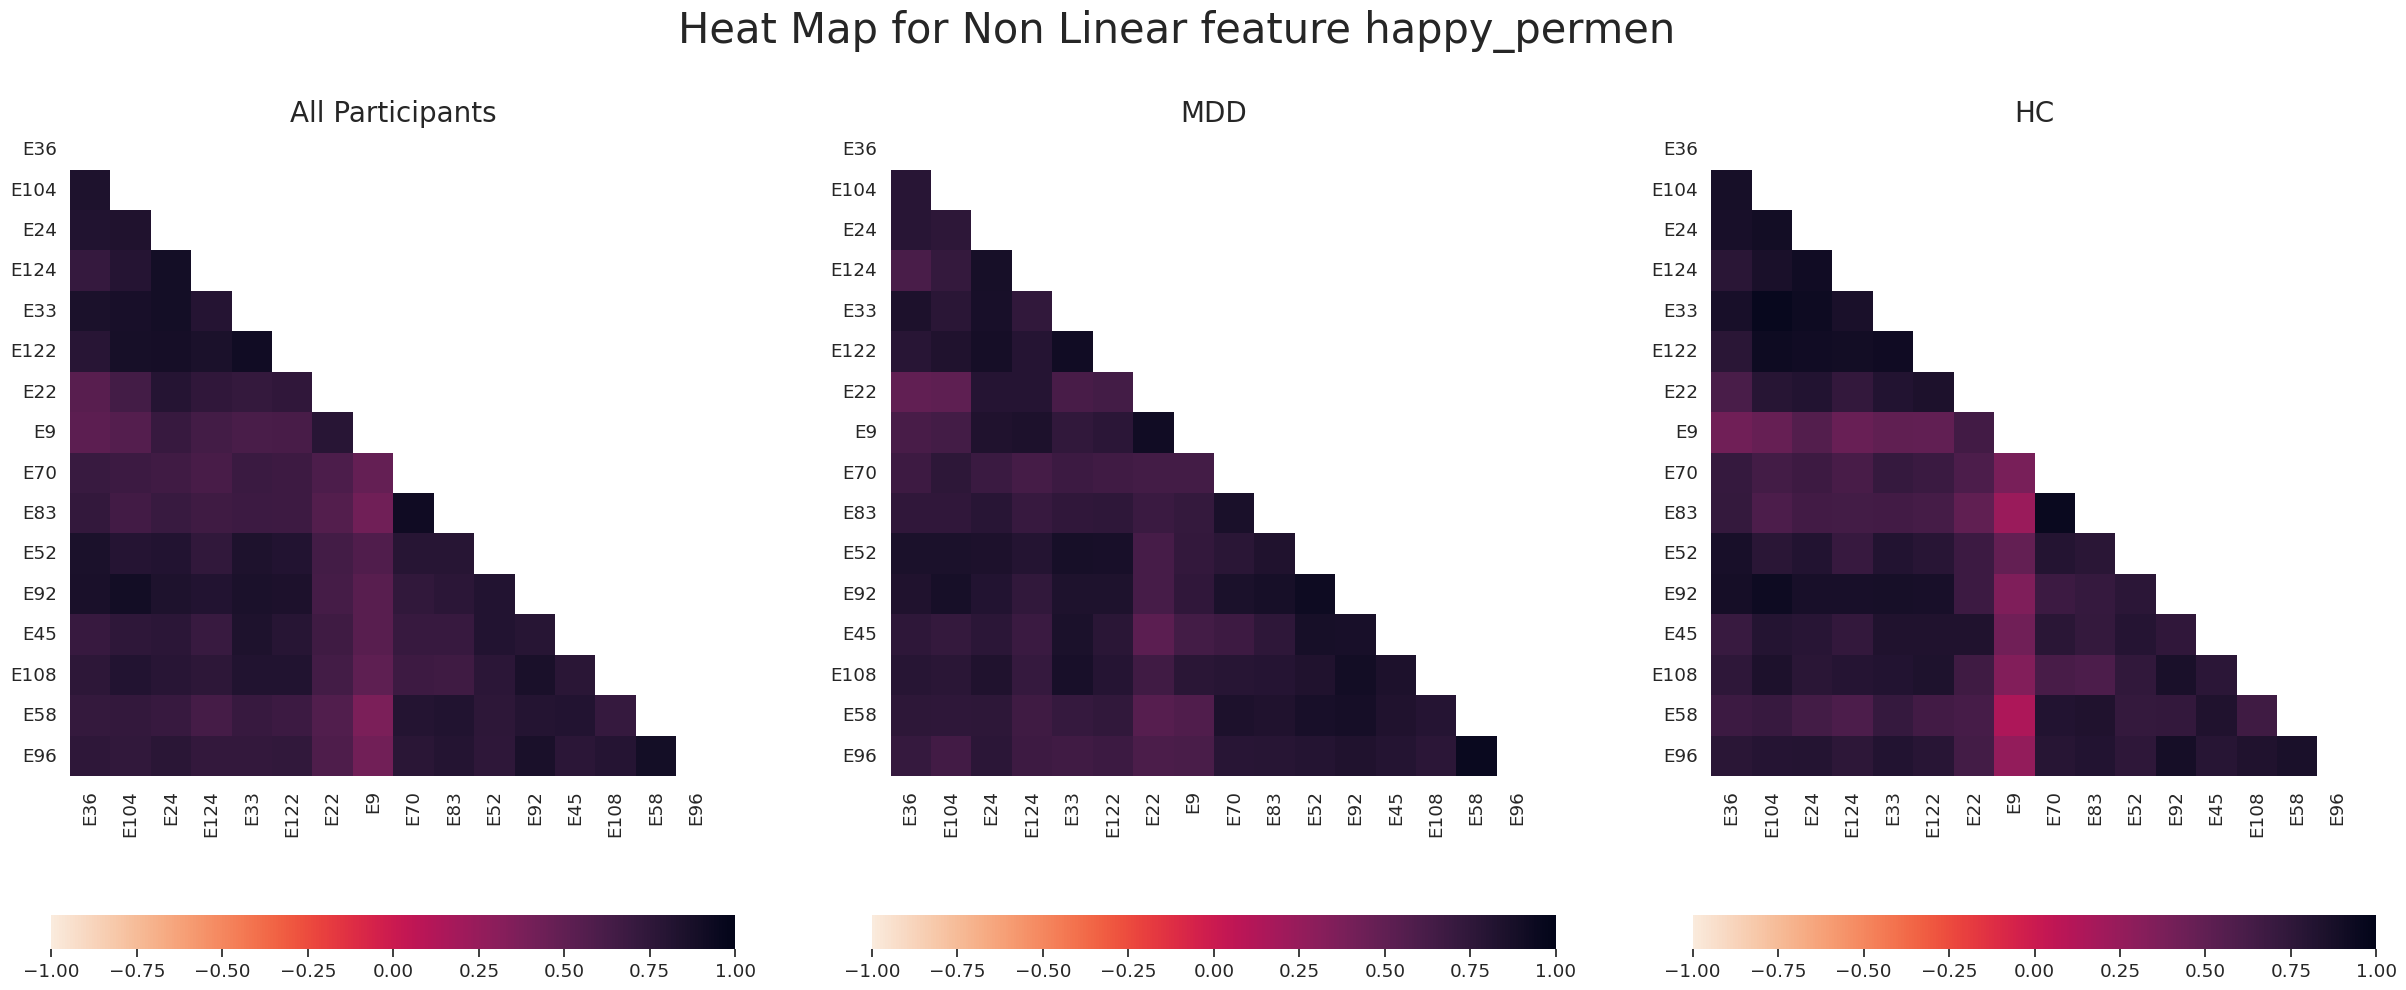

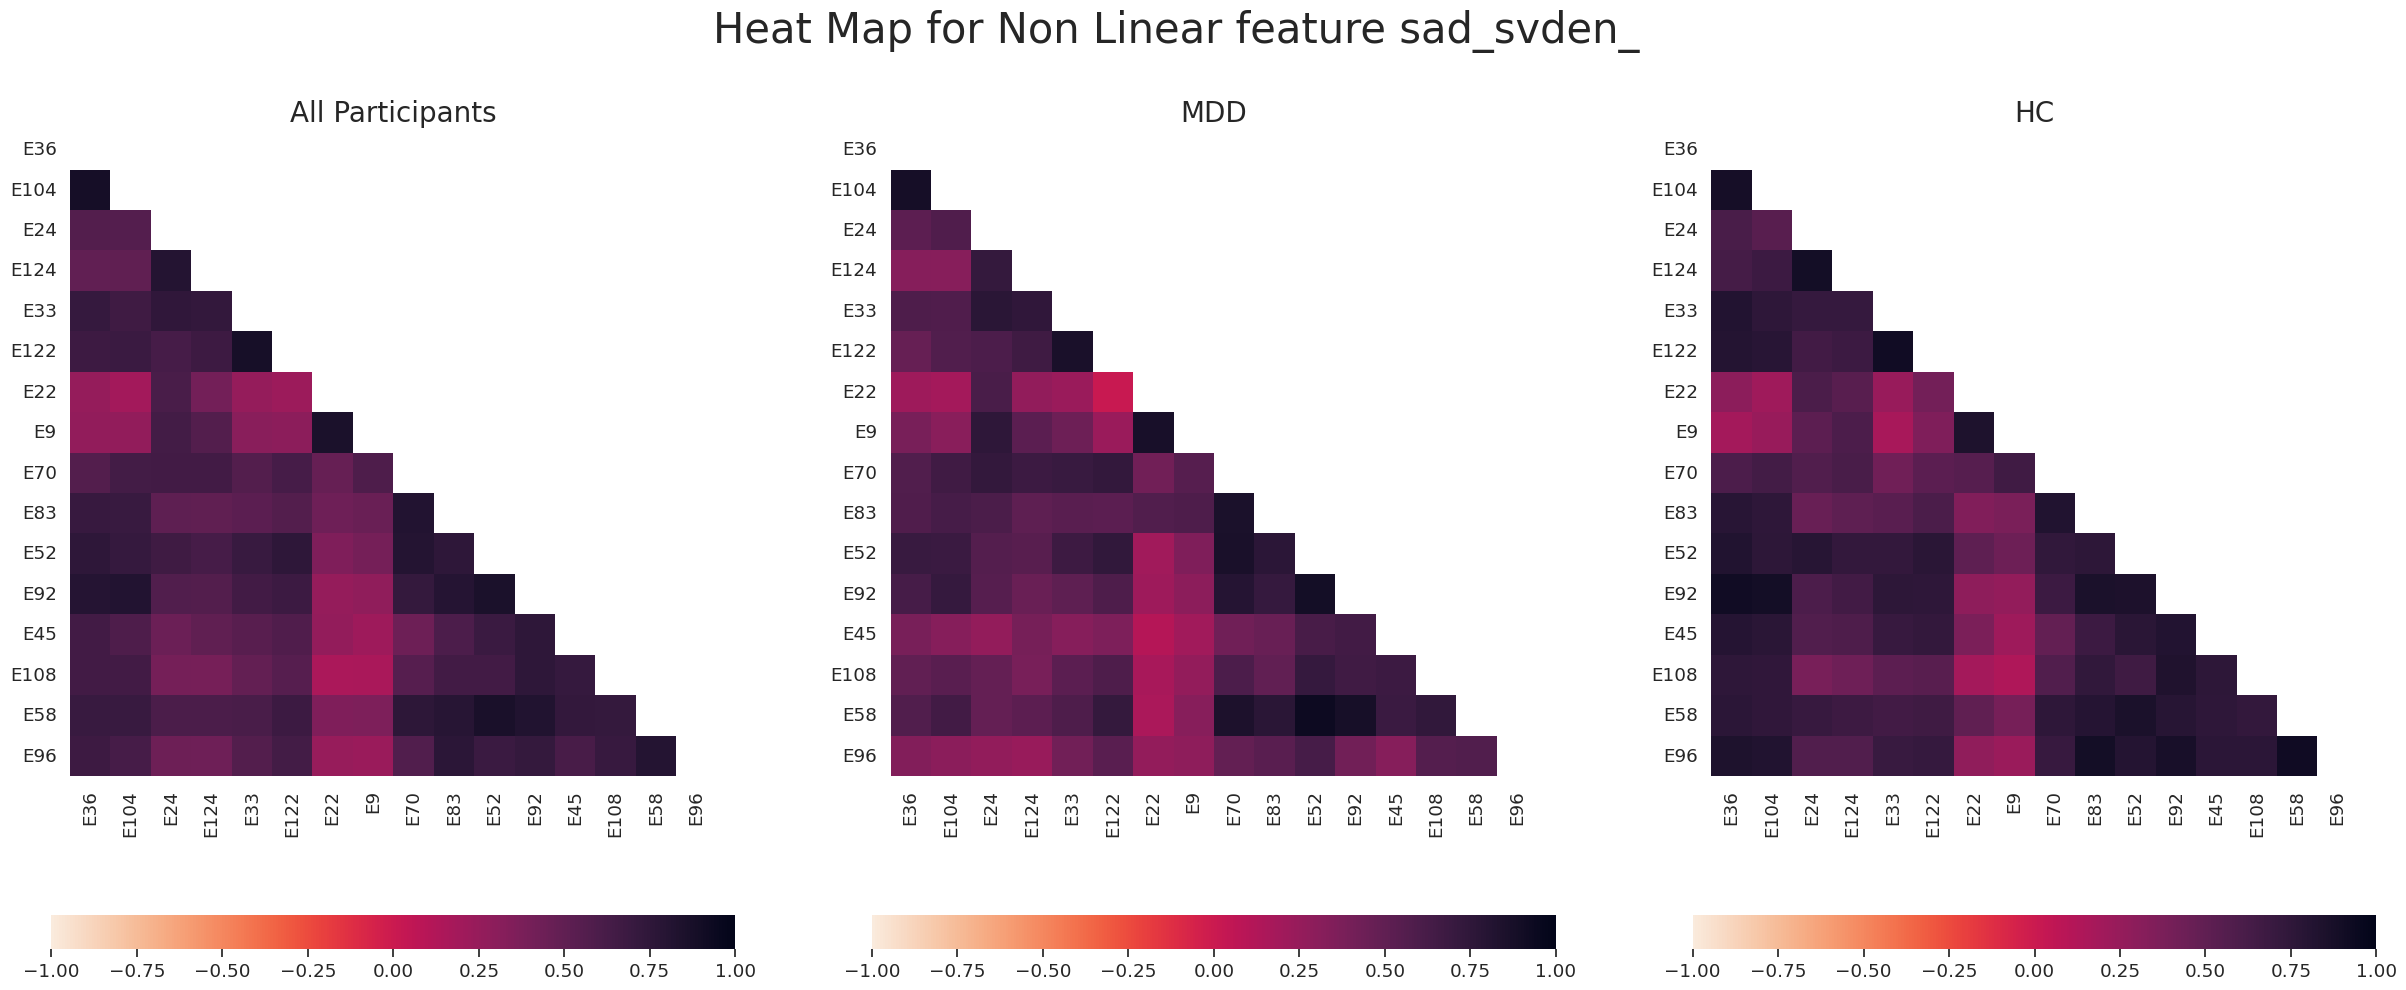

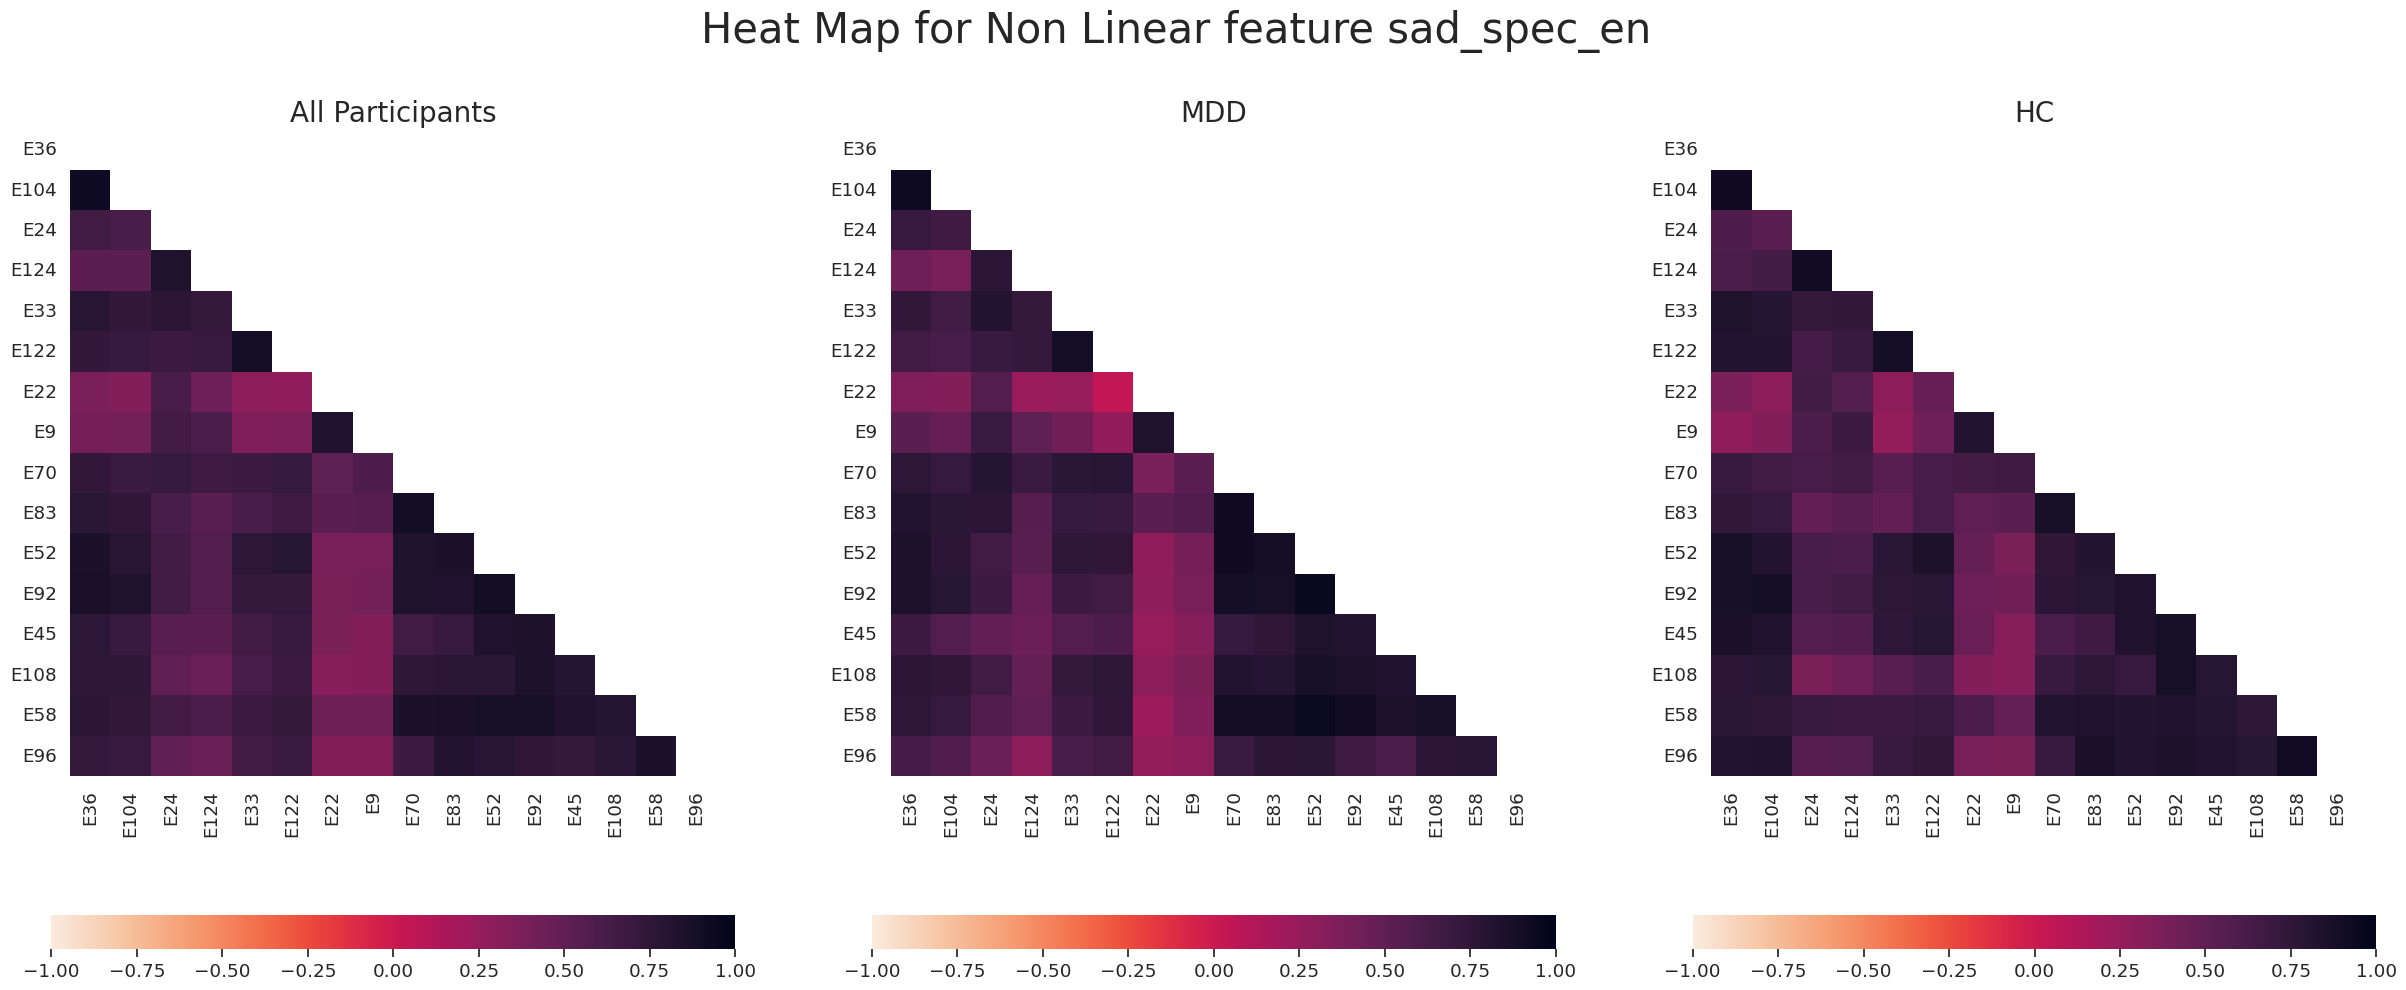

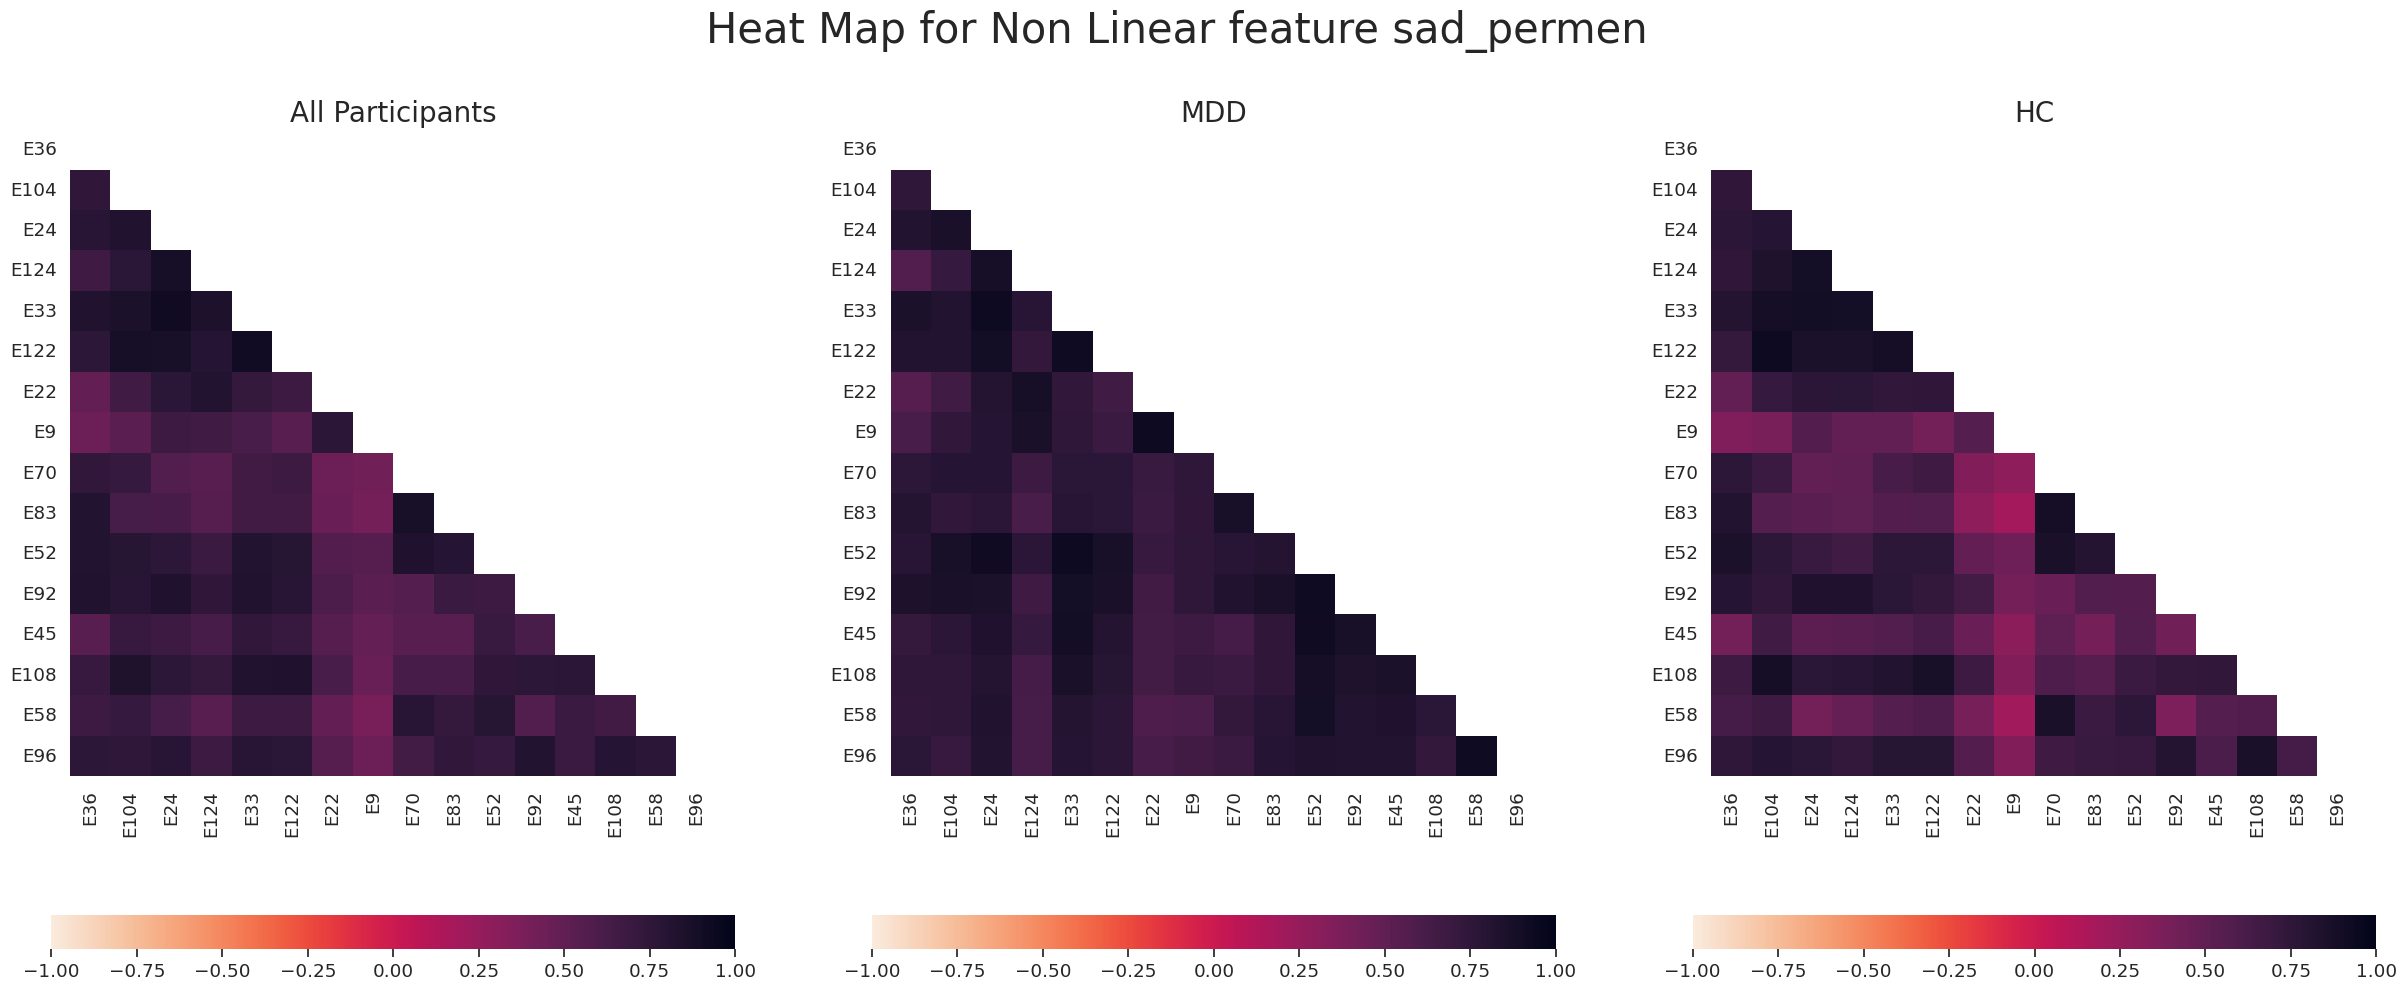

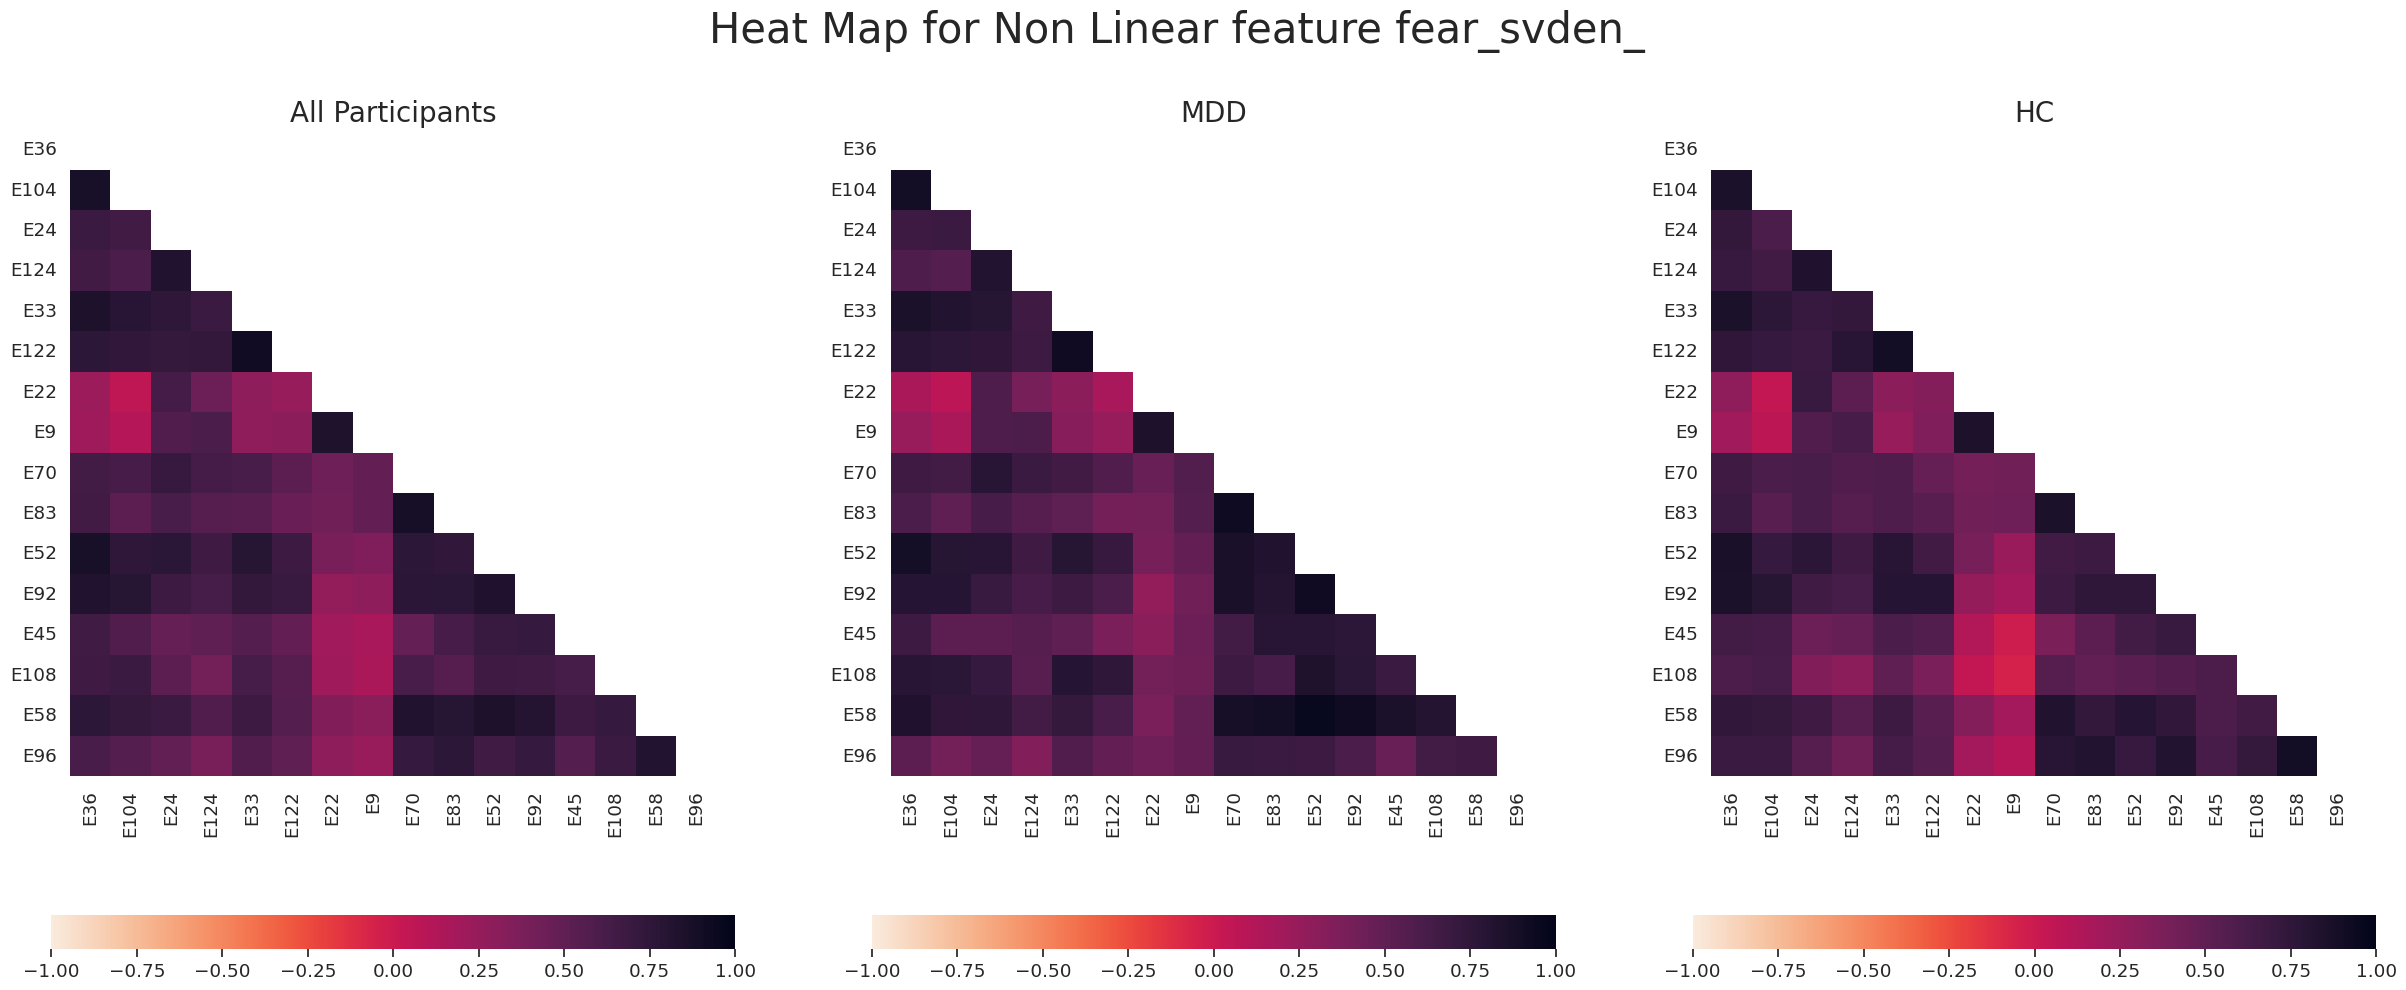

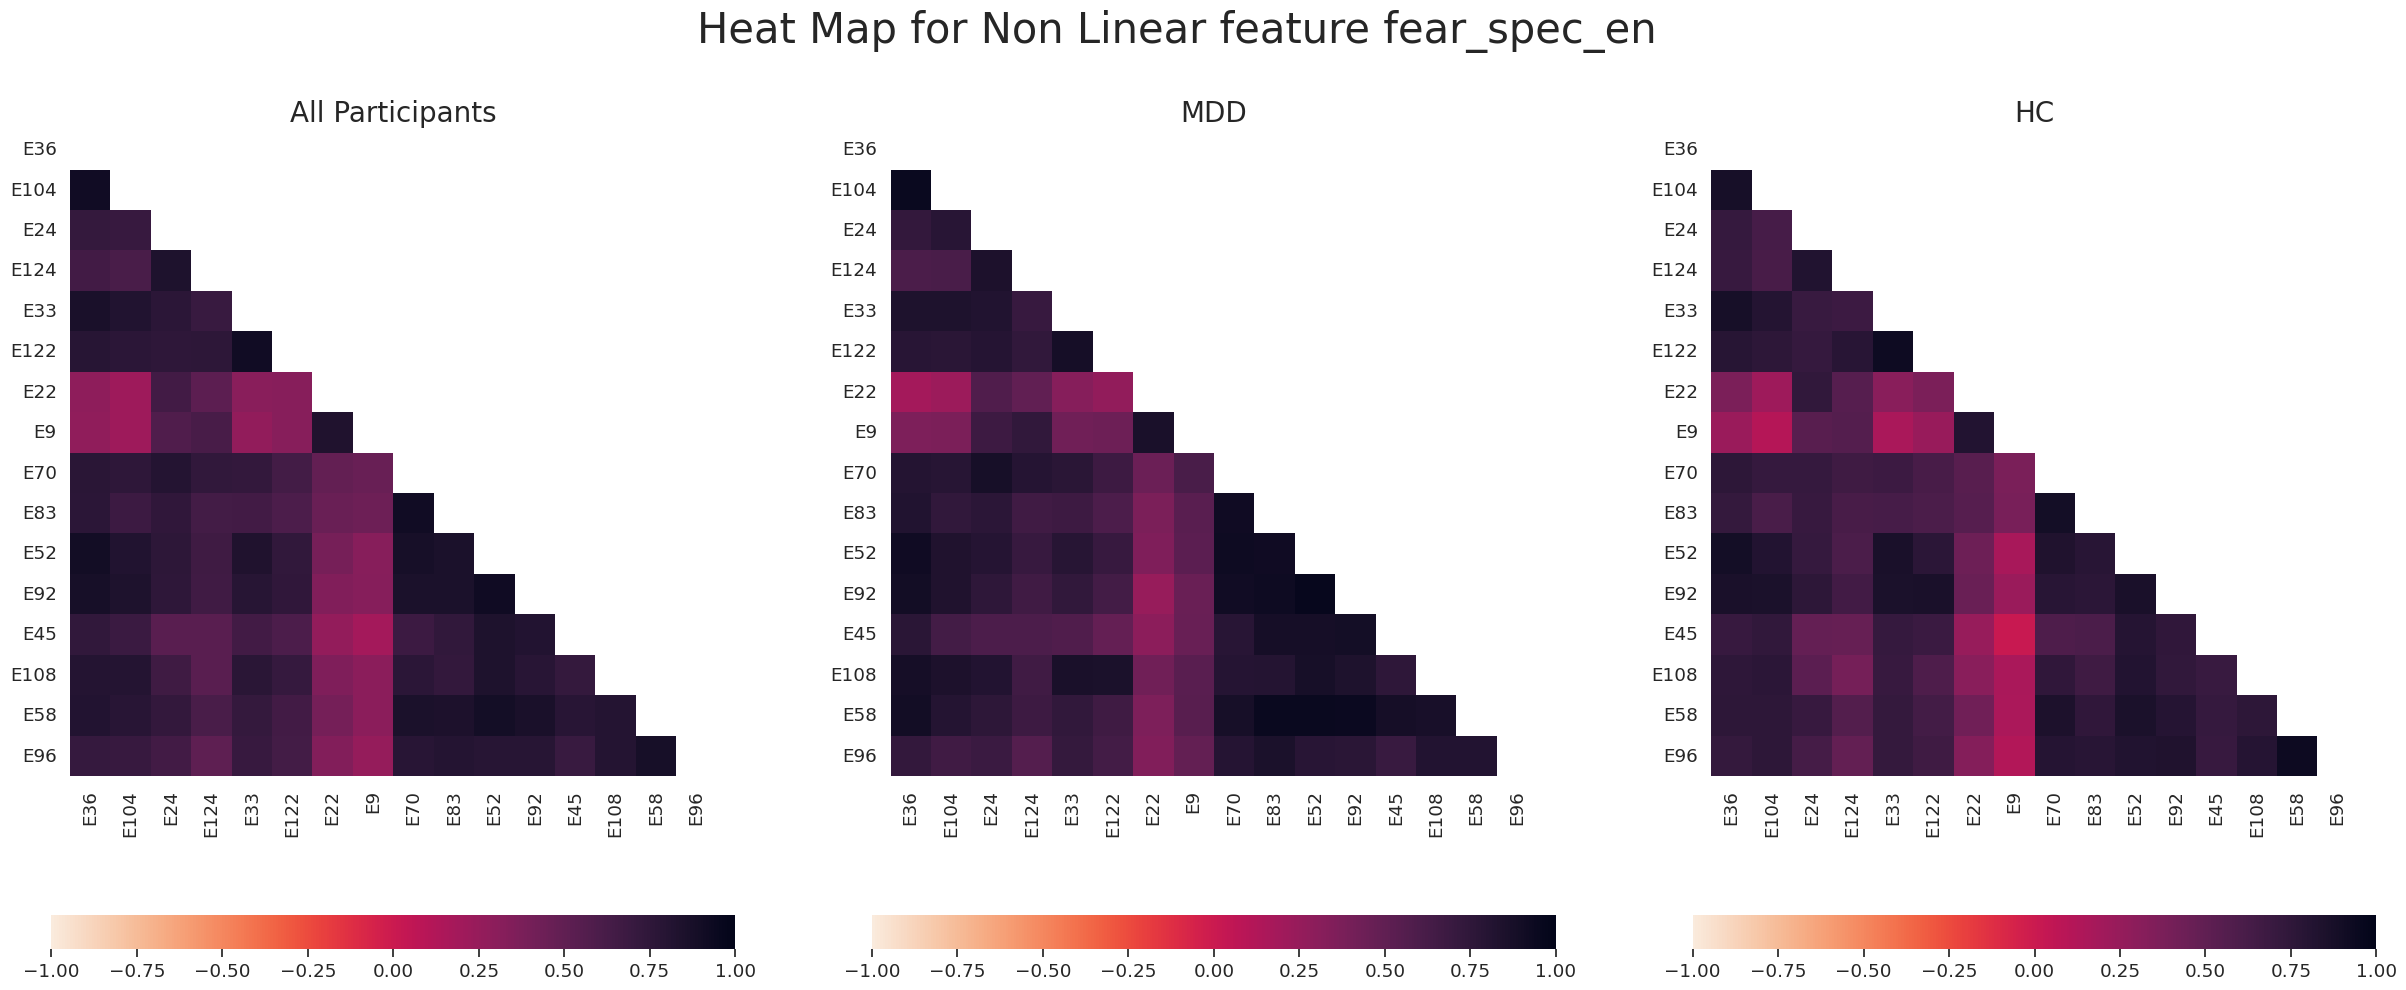

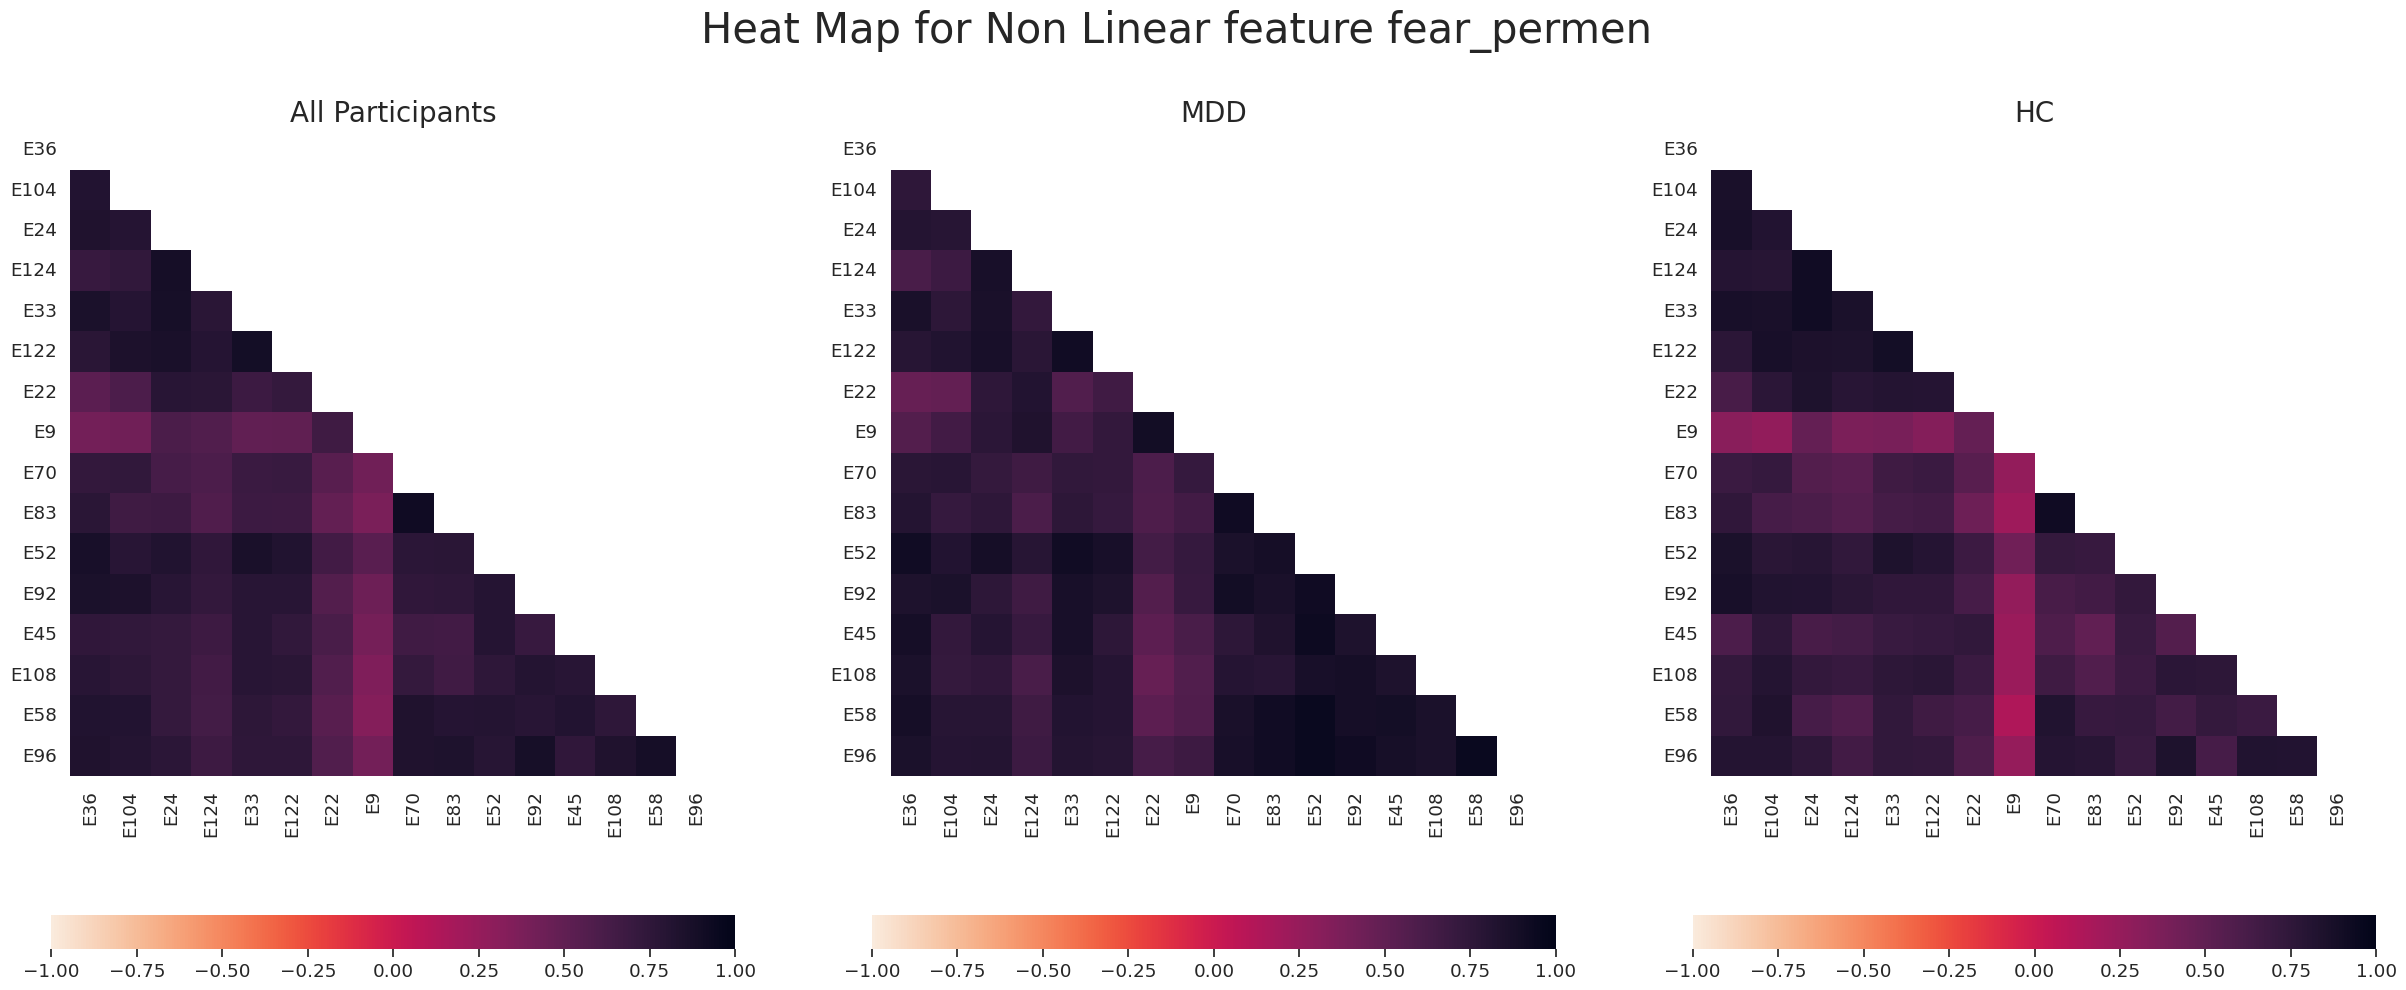

In [ ]:
emotion = 'fear'
for emotion in ['happy','sad','fear']:
  for name in ['svden_','spec_en','permen']:
    temp = columns_extractor(df,emotion,'nl',name)
    a,b = correlation_builder(temp,prefix = 'Non Linear feature '+emotion+'_'+name)
    temp.drop(columns = 'type',inplace=True)
    columns_to_keep.extend(['nl_'+name+emotion+'_'+i for i in temp.columns[column_eliminator(a,thr = 0.8)]])

It can be seen that the correlation between the non linear features is pretty high for all the emotions, so removing these features may change the efficiency of our model

In [ ]:
len(columns_to_keep)

239

## Model Training

In [ ]:
df.type.replace({'MDD':1, 'HC':0},inplace=True)

In [ ]:
X = df.drop(columns="type")
y = df["type"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [ ]:
scalar = StandardScaler()
X_scale_train = scalar.fit_transform(X_train)
X_scale_test = scalar.transform(X_test)

## Classification using RNN

In [ ]:
def create_model(X):
  inputs = Input(shape=(X.shape[1],))
  expand_dims = tf.expand_dims(inputs, axis=2)
  gru = GRU(256, return_sequences=True)(expand_dims)
  gru = GRU(256, return_sequences=True)(gru)
  #gru = GRU(256, return_sequences=True)(gru)
  flatten = Flatten()(gru)
  outLayer = Reshape((1, flatten.get_shape()[1]), name='reshape1')(flatten)
  #outLayer = LSTM(64, return_sequences=True)(outLayer)
  outputs = Dense(2, activation='softmax')(outLayer)


  model = Model(inputs=inputs, outputs=outputs)
  print(model.summary())
  model.compile(
    optimizer=Adam(lr=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )


  return model

In [ ]:


# model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

def run_model(model, X, y):
  history = model.fit(
      X,
      y,
      validation_split=0.2,
      batch_size=32,
      epochs=25,
      callbacks=[
          tf.keras.callbacks.EarlyStopping(
              monitor='val_loss',
              patience=5,
              restore_best_weights=True
          )
      ]
  )
  return history

In [ ]:
Dmodel= create_model(X_scale_train)
rnn_model = run_model(model, X_scale_train, y_train)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 239)]             0         
                                                                 
 tf.expand_dims_2 (TFOpLamb  (None, 239, 1)            0         
 da)                                                             
                                                                 
 gru (GRU)                   (None, 239, 256)          198912    
                                                                 
 gru_1 (GRU)                 (None, 239, 256)          394752    
                                                                 
 flatten_2 (Flatten)         (None, 61184)             0         
                                                                 
 reshape1 (Reshape)          (None, 1, 61184)          0         
                                                           

None
Epoch 1/25
1/1 [==============================] - 7s 7s/step - loss: 0.7066 - accuracy: 0.3548 - val_loss: 0.8448 - val_accuracy: 0.5000
Epoch 2/25
1/1 [==============================] - 1s 1s/step - loss: 0.5428 - accuracy: 0.6452 - val_loss: 0.9329 - val_accuracy: 0.3750
Epoch 3/25
1/1 [==============================] - 1s 1s/step - loss: 0.4750 - accuracy: 0.7097 - val_loss: 0.7662 - val_accuracy: 0.5000
Epoch 4/25
1/1 [==============================] - 1s 1s/step - loss: 0.4058 - accuracy: 0.7742 - val_loss: 0.6157 - val_accuracy: 0.6250
Epoch 5/25
1/1 [==============================] - 1s 1s/step - loss: 0.3664 - accuracy: 0.8710 - val_loss: 0.5281 - val_accuracy: 0.8750
Epoch 6/25
1/1 [==============================] - 2s 2s/step - loss: 0.3070 - accuracy: 0.8710 - val_loss: 0.4981 - val_accuracy: 0.8750
Epoch 7/25
1/1 [==============================] - 2s 2s/step - loss: 0.2683 - accuracy: 0.8710 - val_loss: 0.5057 - val_accuracy: 0.8750
Epoch 8/25
1/1 [====================

In [ ]:
model_acc = model.evaluate(X_scale_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 64.286%


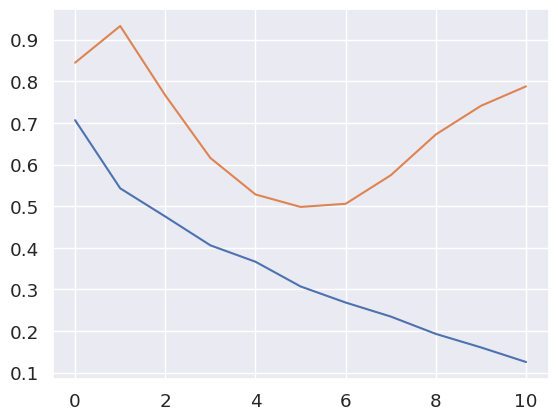

In [ ]:
plt.plot(rnn_model.history["loss"])
plt.plot(rnn_model.history["val_loss"])

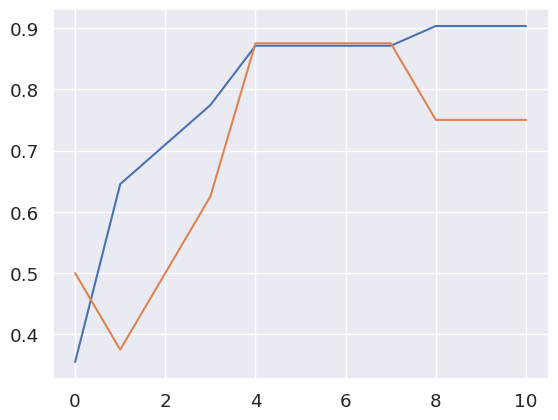

In [ ]:
plt.plot(rnn_model.history["accuracy"])
plt.plot(rnn_model.history["val_accuracy"])

In [ ]:
X_scale_train.shape[1]

528

In [ ]:
def model_lstm(X):
  inputs = Input(shape=(X.shape[1],))
  expand_dims = tf.expand_dims(inputs, axis=2)
  model = LSTM(256, return_sequences=True)(expand_dims)
  model = LSTM(256, return_sequences=True)(model)
  model = GRU(256, return_sequences=True)(model)
  model = GRU(256, return_sequences=True)(model)
  model = Dropout(0.5)(model)
  flatten = Flatten()(model)
  outLayer = Reshape((1, flatten.get_shape()[1]), name='reshape1')(flatten)
  outputs = Dense(1, activation='sigmoid')(outLayer)


  model = Model(inputs=inputs, outputs=outputs)
  print(model.summary())
  model.compile(
    optimizer=Adam(lr=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )
  return model

In [ ]:


  # model = Sequential()
  # model.add(LSTM(256, input_shape=(X.shape[1], 1), activation="relu", return_sequences=True))
  # model.add(LSTM(256, activation="relu"))
  # model.add(LSTM(256, activation="relu"))  # Change return_sequences to False
  # #model.add(Dropout(0.2))
  # #model.add(LSTM(50))
  # #model.add(Dropout(0.2))
  # #flatten = Flatten()(lstm)
  # #outLayer = Reshape((1, flatten.get_shape()[1]), name='reshape1')(flatten)
  # model.add(Dense(1, activation='softmax'))
  # #model = Model(inputs=inputs, outputs=outputs)
  # model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
  # model.summary()
  # return model

In [ ]:
lstm = model_lstm(X_scale_train)
history = lstm.fit(
      X_scale_train,
      y_train,
      validation_data=(X_scale_test, y_test),
      batch_size=32,
      epochs=30,
      callbacks=[
          tf.keras.callbacks.EarlyStopping(
              monitor='val_loss',
              patience=5,
              restore_best_weights=True
          )
      ]
  )


Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 528)]             0         
                                                                 
 tf.expand_dims_45 (TFOpLam  (None, 528, 1)            0         
 bda)                                                            
                                                                 
 lstm_117 (LSTM)             (None, 528, 256)          264192    
                                                                 
 lstm_118 (LSTM)             (None, 528, 256)          525312    
                                                                 
 gru_26 (GRU)                (None, 528, 256)          394752    
                                                                 
 gru_27 (GRU)                (None, 528, 256)          394752    
                                                          

None
Epoch 1/30
2/2 [==============================] - 23s 8s/step - loss: 0.6983 - accuracy: 0.4103 - val_loss: 0.6288 - val_accuracy: 0.5714
Epoch 2/30
2/2 [==============================] - 14s 7s/step - loss: 0.6413 - accuracy: 0.6410 - val_loss: 0.6052 - val_accuracy: 0.5000
Epoch 3/30
2/2 [==============================] - 13s 6s/step - loss: 0.5496 - accuracy: 0.7179 - val_loss: 0.7893 - val_accuracy: 0.4286
Epoch 4/30
2/2 [==============================] - 13s 6s/step - loss: 0.5350 - accuracy: 0.7179 - val_loss: 0.8109 - val_accuracy: 0.5000
Epoch 5/30
2/2 [==============================] - 13s 6s/step - loss: 0.4569 - accuracy: 0.8205 - val_loss: 1.0137 - val_accuracy: 0.5714
Epoch 6/30
2/2 [==============================] - 13s 7s/step - loss: 0.4327 - accuracy: 0.7436 - val_loss: 1.5834 - val_accuracy: 0.4286
Epoch 7/30
2/2 [==============================] - 13s 6s/step - loss: 0.3932 - accuracy: 0.8462 - val_loss: 2.1153 - val_accuracy: 0.2857


In [ ]:
model_acc = lstm.evaluate(X_scale_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 71.429%


## Using Classification Models

In [ ]:
def classifier(X,y,X_test,y_test):
  """
  Input:

  X - Training set
  y - Training outcome
  X_test - Test set
  y_test - Test outcome

  Output :
  total - dictionary summarizing performances of various models

  """
  total = dict()
  rf = RandomForestClassifier(random_state=42)
  lr = LogisticRegression(random_state=42)
  knn = KNeighborsClassifier()
  svc = SVC(random_state=42)
  model_array = [rf,lr,knn,svc]
  model_vals = ['Random Forest','Logistic Regression','KNeighbors Classifier','SVC']
  i = 0
  for clf in model_array:
    result = dict()
    kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    result['accuracy']=round(accuracy_score(y_test, y_pred),2)
    result['precision']=round(precision_score(y_test, y_pred),2)
    result['recall']=round(recall_score(y_test, y_pred),2)
    total[model_vals[i]]=result
    i = i+1

  return total

In [ ]:
result = pd.DataFrame(classifier(X_scale_train,y_train,X_scale_test,y_test))
result['base'] = 'PCA factors'
result['emotion'] = 'all'

In [ ]:
print(result)

           Random Forest  Logistic Regression  KNeighbors Classifier   SVC  \
accuracy            0.64                 0.57                   0.64  0.57   
precision           0.62                 0.57                   0.62  1.00   
recall              0.71                 0.57                   0.71  0.14   

                  base emotion  
accuracy   PCA factors     all  
precision  PCA factors     all  
recall     PCA factors     all  


In [ ]:
final =result.reset_index()

In [ ]:
Vals = list(X_train.columns)

## Application of Classification Models and RNN to individual features

In [ ]:
for emotion in 'sad':
  for type_vars in 'lf':
    indices_to_keep_lf = [i for i in range(len(Vals)) if type_vars in Vals[i] and emotion in Vals[i]]

In [ ]:
temp_model= model_lstm(X_scale_train[:,indices_to_keep_lf])

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 208)]             0         
                                                                 
 tf.expand_dims_44 (TFOpLam  (None, 208, 1)            0         
 bda)                                                            
                                                                 
 lstm_115 (LSTM)             (None, 208, 256)          264192    
                                                                 
 lstm_116 (LSTM)             (None, 208, 256)          525312    
                                                                 
 gru_24 (GRU)                (None, 208, 256)          394752    
                                                                 
 gru_25 (GRU)                (None, 208, 256)          394752    
                                                          

None


In [ ]:
history = temp_model.fit(
      X_scale_train[:,indices_to_keep_lf],
      y_train,
      validation_data=(X_scale_test[:,indices_to_keep_lf], y_test),
      batch_size=32,
      epochs=30,
      callbacks=[
          tf.keras.callbacks.EarlyStopping(
              monitor='val_loss',
              patience=5,
              restore_best_weights=True
          )
      ]
  )

Epoch 1/30
2/2 [==============================] - 14s 4s/step - loss: 0.6902 - accuracy: 0.5641 - val_loss: 0.5526 - val_accuracy: 0.7143
Epoch 2/30
2/2 [==============================] - 6s 2s/step - loss: 0.6393 - accuracy: 0.5385 - val_loss: 0.5560 - val_accuracy: 0.5714
Epoch 3/30
2/2 [==============================] - 5s 2s/step - loss: 0.6093 - accuracy: 0.5641 - val_loss: 0.5092 - val_accuracy: 0.7143
Epoch 4/30
2/2 [==============================] - 6s 3s/step - loss: 0.5941 - accuracy: 0.6667 - val_loss: 0.5823 - val_accuracy: 0.7143
Epoch 5/30
2/2 [==============================] - 5s 2s/step - loss: 0.5587 - accuracy: 0.6667 - val_loss: 0.6536 - val_accuracy: 0.5714
Epoch 6/30
2/2 [==============================] - 6s 3s/step - loss: 0.5589 - accuracy: 0.6667 - val_loss: 0.8141 - val_accuracy: 0.2857
Epoch 7/30
2/2 [==============================] - 5s 2s/step - loss: 0.5528 - accuracy: 0.5897 - val_loss: 1.0380 - val_accuracy: 0.4286
Epoch 8/30
2/2 [========================

In [ ]:
model_acc = temp_model.evaluate(X_scale_test[:,indices_to_keep_lf], y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 71.429%


In [ ]:
for emotion in ['fear','sad','happy','erp','all']:
  for type_vars in ['nl','lf','all']:
    if emotion =='erp':
      indices_to_keep = [i for i in range(len(Vals)) if type_vars in Vals[i] and 'resting' not in Vals[i]]
      if type_vars =='all':
        indices_to_keep = [i for i in range(len(Vals)) if 'resting' not in Vals[i]]
    elif emotion =='all':
      indices_to_keep = [i for i in range(len(Vals)) if type_vars in Vals[i]]
      if type_vars =='all':
        indices_to_keep = [i for i in range(len(Vals))]
    else:
      indices_to_keep = [i for i in range(len(Vals)) if type_vars in Vals[i] and emotion in Vals[i]]
      if type_vars =='all':
        indices_to_keep = [i for i in range(len(Vals)) if emotion in Vals[i]]

    print(f"Creating Model with {emotion} emotion and {type_vars} features")
    temp_model= create_model(X_scale_train[:,indices_to_keep])
    hist_rnn_model = run_model(temp_model, X_scale_train[:,indices_to_keep], y_train)
    new_model_acc = temp_model.evaluate(X_scale_test[:,indices_to_keep], y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(new_model_acc * 100))
    #temp = classifier(X_scale_train[:,indices_to_keep],y_train,X_scale_test[:,indices_to_keep],y_test)
    #temp['base'] = type_vars
    #temp['emotion'] = emotion
    #final = pd.concat([final,pd.DataFrame(temp).reset_index()],axis = 0)
    #print(temp)

Creating Model with fear emotion and nl features
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 14)]              0         
                                                                 
 tf.expand_dims_7 (TFOpLamb  (None, 14, 1)             0         
 da)                                                             
                                                                 
 gru_4 (GRU)                 (None, 14, 256)           198912    
                                                                 
 gru_5 (GRU)                 (None, 14, 256)           394752    
                                                                 
 flatten_7 (Flatten)         (None, 3584)              0         
                                                                 
 reshape1 (Reshape)          (None, 1, 3584)           0         
          

None
Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 0.6907 - accuracy: 0.5806 - val_loss: 0.7132 - val_accuracy: 0.3750
Epoch 2/25
1/1 [==============================] - 0s 184ms/step - loss: 0.6626 - accuracy: 0.5806 - val_loss: 0.7541 - val_accuracy: 0.2500
Epoch 3/25
1/1 [==============================] - 0s 184ms/step - loss: 0.6497 - accuracy: 0.6129 - val_loss: 0.7893 - val_accuracy: 0.2500
Epoch 4/25
1/1 [==============================] - 0s 181ms/step - loss: 0.6382 - accuracy: 0.6129 - val_loss: 0.8103 - val_accuracy: 0.2500
Epoch 5/25
1/1 [==============================] - 0s 174ms/step - loss: 0.6273 - accuracy: 0.6452 - val_loss: 0.8374 - val_accuracy: 0.3750
Epoch 6/25
1/1 [==============================] - 0s 174ms/step - loss: 0.6246 - accuracy: 0.7097 - val_loss: 0.8830 - val_accuracy: 0.3750
Test Accuracy: 35.714%
Creating Model with fear emotion and lf features
Model: "model_8"
_________________________________________________________________
 La

None
Epoch 1/25
1/1 [==============================] - 5s 5s/step - loss: 0.7021 - accuracy: 0.4516 - val_loss: 0.7917 - val_accuracy: 0.2500
Epoch 2/25
1/1 [==============================] - 0s 360ms/step - loss: 0.6252 - accuracy: 0.6129 - val_loss: 0.9699 - val_accuracy: 0.2500
Epoch 3/25
1/1 [==============================] - 0s 354ms/step - loss: 0.5852 - accuracy: 0.6129 - val_loss: 1.0938 - val_accuracy: 0.2500
Epoch 4/25
1/1 [==============================] - 0s 362ms/step - loss: 0.5593 - accuracy: 0.6129 - val_loss: 1.0139 - val_accuracy: 0.2500
Epoch 5/25
1/1 [==============================] - 0s 383ms/step - loss: 0.5338 - accuracy: 0.5806 - val_loss: 0.8233 - val_accuracy: 0.3750
Epoch 6/25
1/1 [==============================] - 0s 375ms/step - loss: 0.5157 - accuracy: 0.7097 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 7/25
1/1 [==============================] - 0s 342ms/step - loss: 0.5064 - accuracy: 0.8065 - val_loss: 0.6726 - val_accuracy: 0.5000
Epoch 8/25
1/1 [==

None
Epoch 1/25
1/1 [==============================] - 5s 5s/step - loss: 0.6976 - accuracy: 0.4516 - val_loss: 0.8176 - val_accuracy: 0.3750
Epoch 2/25
1/1 [==============================] - 0s 387ms/step - loss: 0.6127 - accuracy: 0.6452 - val_loss: 1.0770 - val_accuracy: 0.3750
Epoch 3/25
1/1 [==============================] - 0s 409ms/step - loss: 0.5665 - accuracy: 0.6452 - val_loss: 1.2337 - val_accuracy: 0.3750
Epoch 4/25
1/1 [==============================] - 0s 413ms/step - loss: 0.5371 - accuracy: 0.6774 - val_loss: 1.1035 - val_accuracy: 0.3750
Epoch 5/25
1/1 [==============================] - 0s 381ms/step - loss: 0.5002 - accuracy: 0.6452 - val_loss: 0.8568 - val_accuracy: 0.2500
Epoch 6/25
1/1 [==============================] - 0s 409ms/step - loss: 0.4693 - accuracy: 0.7419 - val_loss: 0.6597 - val_accuracy: 0.6250
Epoch 7/25
1/1 [==============================] - 1s 593ms/step - loss: 0.4461 - accuracy: 0.8065 - val_loss: 0.5893 - val_accuracy: 0.7500
Epoch 8/25
1/1 [==

None
Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 0.6840 - accuracy: 0.5806 - val_loss: 0.6983 - val_accuracy: 0.6250
Epoch 2/25
1/1 [==============================] - 0s 147ms/step - loss: 0.6333 - accuracy: 0.6774 - val_loss: 0.7504 - val_accuracy: 0.6250
Epoch 3/25
1/1 [==============================] - 0s 144ms/step - loss: 0.6148 - accuracy: 0.7097 - val_loss: 0.7964 - val_accuracy: 0.6250
Epoch 4/25
1/1 [==============================] - 0s 145ms/step - loss: 0.6040 - accuracy: 0.7419 - val_loss: 0.8080 - val_accuracy: 0.5000
Epoch 5/25
1/1 [==============================] - 0s 152ms/step - loss: 0.5840 - accuracy: 0.7742 - val_loss: 0.8188 - val_accuracy: 0.5000
Epoch 6/25
1/1 [==============================] - 0s 142ms/step - loss: 0.5694 - accuracy: 0.7419 - val_loss: 0.8516 - val_accuracy: 0.3750
Test Accuracy: 14.286%
Creating Model with sad emotion and lf features
Model: "model_11"
_________________________________________________________________
 La

None
Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 0.6849 - accuracy: 0.5806 - val_loss: 0.6806 - val_accuracy: 0.6250
Epoch 2/25
1/1 [==============================] - 0s 393ms/step - loss: 0.5875 - accuracy: 0.6129 - val_loss: 0.7182 - val_accuracy: 0.6250
Epoch 3/25
1/1 [==============================] - 0s 420ms/step - loss: 0.5493 - accuracy: 0.5806 - val_loss: 0.7308 - val_accuracy: 0.6250
Epoch 4/25
1/1 [==============================] - 0s 384ms/step - loss: 0.5308 - accuracy: 0.5806 - val_loss: 0.6586 - val_accuracy: 0.6250
Epoch 5/25
1/1 [==============================] - 0s 373ms/step - loss: 0.5028 - accuracy: 0.6129 - val_loss: 0.5937 - val_accuracy: 0.3750
Epoch 6/25
1/1 [==============================] - 0s 375ms/step - loss: 0.4875 - accuracy: 0.7742 - val_loss: 0.5697 - val_accuracy: 0.3750
Epoch 7/25
1/1 [==============================] - 0s 385ms/step - loss: 0.4774 - accuracy: 0.8065 - val_loss: 0.5660 - val_accuracy: 0.5000
Epoch 8/25
1/1 [==

None
Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 0.6968 - accuracy: 0.3548 - val_loss: 0.6589 - val_accuracy: 0.7500
Epoch 2/25
1/1 [==============================] - 0s 452ms/step - loss: 0.5789 - accuracy: 0.6452 - val_loss: 0.6691 - val_accuracy: 0.7500
Epoch 3/25
1/1 [==============================] - 0s 457ms/step - loss: 0.5069 - accuracy: 0.6774 - val_loss: 0.7465 - val_accuracy: 0.6250
Epoch 4/25
1/1 [==============================] - 0s 441ms/step - loss: 0.4774 - accuracy: 0.7097 - val_loss: 0.7751 - val_accuracy: 0.3750
Epoch 5/25
1/1 [==============================] - 0s 468ms/step - loss: 0.4638 - accuracy: 0.7742 - val_loss: 0.7175 - val_accuracy: 0.5000
Epoch 6/25
1/1 [==============================] - 0s 431ms/step - loss: 0.4422 - accuracy: 0.8065 - val_loss: 0.6422 - val_accuracy: 0.5000
Epoch 7/25
1/1 [==============================] - 0s 470ms/step - loss: 0.4142 - accuracy: 0.8065 - val_loss: 0.6043 - val_accuracy: 0.5000
Epoch 8/25
1/1 [==

None
Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 0.6890 - accuracy: 0.5484 - val_loss: 0.6731 - val_accuracy: 0.5000
Epoch 2/25
1/1 [==============================] - 0s 159ms/step - loss: 0.6506 - accuracy: 0.5484 - val_loss: 0.7242 - val_accuracy: 0.5000
Epoch 3/25
1/1 [==============================] - 0s 210ms/step - loss: 0.6442 - accuracy: 0.5484 - val_loss: 0.7294 - val_accuracy: 0.6250
Epoch 4/25
1/1 [==============================] - 0s 156ms/step - loss: 0.6307 - accuracy: 0.5484 - val_loss: 0.7201 - val_accuracy: 0.6250
Epoch 5/25
1/1 [==============================] - 0s 156ms/step - loss: 0.6151 - accuracy: 0.6129 - val_loss: 0.7357 - val_accuracy: 0.6250
Epoch 6/25
1/1 [==============================] - 0s 202ms/step - loss: 0.6066 - accuracy: 0.7097 - val_loss: 0.7737 - val_accuracy: 0.5000
Test Accuracy: 42.857%
Creating Model with happy emotion and lf features
Model: "model_14"
_________________________________________________________________
 

None
Epoch 1/25
1/1 [==============================] - 7s 7s/step - loss: 0.7034 - accuracy: 0.4194 - val_loss: 0.7603 - val_accuracy: 0.3750
Epoch 2/25
1/1 [==============================] - 0s 398ms/step - loss: 0.6373 - accuracy: 0.5484 - val_loss: 0.8340 - val_accuracy: 0.3750
Epoch 3/25
1/1 [==============================] - 0s 417ms/step - loss: 0.6056 - accuracy: 0.5484 - val_loss: 0.8542 - val_accuracy: 0.2500
Epoch 4/25
1/1 [==============================] - 0s 366ms/step - loss: 0.5710 - accuracy: 0.6452 - val_loss: 0.8170 - val_accuracy: 0.2500
Epoch 5/25
1/1 [==============================] - 0s 374ms/step - loss: 0.5407 - accuracy: 0.7419 - val_loss: 0.7601 - val_accuracy: 0.3750
Epoch 6/25
1/1 [==============================] - 0s 369ms/step - loss: 0.5177 - accuracy: 0.7742 - val_loss: 0.7226 - val_accuracy: 0.5000
Epoch 7/25
1/1 [==============================] - 0s 388ms/step - loss: 0.4905 - accuracy: 0.7742 - val_loss: 0.7117 - val_accuracy: 0.5000
Epoch 8/25
1/1 [==

None
Epoch 1/25
1/1 [==============================] - 7s 7s/step - loss: 0.6860 - accuracy: 0.5806 - val_loss: 0.7333 - val_accuracy: 0.5000
Epoch 2/25
1/1 [==============================] - 0s 495ms/step - loss: 0.6034 - accuracy: 0.7419 - val_loss: 0.8473 - val_accuracy: 0.5000
Epoch 3/25
1/1 [==============================] - 1s 524ms/step - loss: 0.5699 - accuracy: 0.7097 - val_loss: 0.8471 - val_accuracy: 0.6250
Epoch 4/25
1/1 [==============================] - 1s 581ms/step - loss: 0.5364 - accuracy: 0.8387 - val_loss: 0.7571 - val_accuracy: 0.6250
Epoch 5/25
1/1 [==============================] - 1s 601ms/step - loss: 0.5015 - accuracy: 0.7742 - val_loss: 0.6813 - val_accuracy: 0.6250
Epoch 6/25
1/1 [==============================] - 1s 610ms/step - loss: 0.4715 - accuracy: 0.8387 - val_loss: 0.6727 - val_accuracy: 0.6250
Epoch 7/25
1/1 [==============================] - 1s 600ms/step - loss: 0.4413 - accuracy: 0.8065 - val_loss: 0.7423 - val_accuracy: 0.6250
Epoch 8/25
1/1 [==

None
Epoch 1/25
1/1 [==============================] - 5s 5s/step - loss: 0.7029 - accuracy: 0.3871 - val_loss: 0.6908 - val_accuracy: 0.5000
Epoch 2/25
1/1 [==============================] - 0s 322ms/step - loss: 0.6430 - accuracy: 0.5806 - val_loss: 0.7481 - val_accuracy: 0.5000
Epoch 3/25
1/1 [==============================] - 0s 328ms/step - loss: 0.6264 - accuracy: 0.6452 - val_loss: 0.7669 - val_accuracy: 0.5000
Epoch 4/25
1/1 [==============================] - 0s 341ms/step - loss: 0.6004 - accuracy: 0.6774 - val_loss: 0.7882 - val_accuracy: 0.5000
Epoch 5/25
1/1 [==============================] - 0s 325ms/step - loss: 0.5794 - accuracy: 0.7097 - val_loss: 0.8491 - val_accuracy: 0.3750
Epoch 6/25
1/1 [==============================] - 0s 332ms/step - loss: 0.5679 - accuracy: 0.6774 - val_loss: 0.9164 - val_accuracy: 0.3750
Test Accuracy: 42.857%
Creating Model with erp emotion and lf features
Model: "model_17"
_________________________________________________________________
 La

None
Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 0.6982 - accuracy: 0.4839 - val_loss: 0.8859 - val_accuracy: 0.3750
Epoch 2/25
1/1 [==============================] - 1s 986ms/step - loss: 0.5734 - accuracy: 0.6774 - val_loss: 0.9842 - val_accuracy: 0.3750
Epoch 3/25
1/1 [==============================] - 1s 1s/step - loss: 0.5158 - accuracy: 0.7097 - val_loss: 0.8248 - val_accuracy: 0.5000
Epoch 4/25
1/1 [==============================] - 1s 1s/step - loss: 0.4518 - accuracy: 0.7097 - val_loss: 0.6722 - val_accuracy: 0.3750
Epoch 5/25
1/1 [==============================] - 2s 2s/step - loss: 0.4155 - accuracy: 0.8387 - val_loss: 0.6142 - val_accuracy: 0.5000
Epoch 6/25
1/1 [==============================] - 1s 1s/step - loss: 0.3603 - accuracy: 0.8387 - val_loss: 0.5912 - val_accuracy: 0.6250
Epoch 7/25
1/1 [==============================] - 1s 1s/step - loss: 0.3271 - accuracy: 0.8387 - val_loss: 0.5705 - val_accuracy: 0.6250
Epoch 8/25
1/1 [=================

None
Epoch 1/25
1/1 [==============================] - 7s 7s/step - loss: 0.6975 - accuracy: 0.4839 - val_loss: 0.9183 - val_accuracy: 0.5000
Epoch 2/25
1/1 [==============================] - 1s 1s/step - loss: 0.5460 - accuracy: 0.6129 - val_loss: 0.9137 - val_accuracy: 0.3750
Epoch 3/25
1/1 [==============================] - 1s 1s/step - loss: 0.4732 - accuracy: 0.7097 - val_loss: 0.7354 - val_accuracy: 0.5000
Epoch 4/25
1/1 [==============================] - 1s 1s/step - loss: 0.4065 - accuracy: 0.8065 - val_loss: 0.6191 - val_accuracy: 0.6250
Epoch 5/25
1/1 [==============================] - 2s 2s/step - loss: 0.3638 - accuracy: 0.8710 - val_loss: 0.5481 - val_accuracy: 0.7500
Epoch 6/25
1/1 [==============================] - 1s 1s/step - loss: 0.3074 - accuracy: 0.8710 - val_loss: 0.5189 - val_accuracy: 0.7500
Epoch 7/25
1/1 [==============================] - 3s 3s/step - loss: 0.2692 - accuracy: 0.8710 - val_loss: 0.5155 - val_accuracy: 0.8750
Epoch 8/25
1/1 [====================

None
Epoch 1/25
1/1 [==============================] - 8s 8s/step - loss: 0.6909 - accuracy: 0.5484 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 2/25
1/1 [==============================] - 0s 305ms/step - loss: 0.6429 - accuracy: 0.6129 - val_loss: 0.7392 - val_accuracy: 0.5000
Epoch 3/25
1/1 [==============================] - 0s 338ms/step - loss: 0.6193 - accuracy: 0.6452 - val_loss: 0.7537 - val_accuracy: 0.6250
Epoch 4/25
1/1 [==============================] - 0s 323ms/step - loss: 0.5932 - accuracy: 0.7097 - val_loss: 0.8013 - val_accuracy: 0.5000
Epoch 5/25
1/1 [==============================] - 0s 346ms/step - loss: 0.5790 - accuracy: 0.6774 - val_loss: 0.8704 - val_accuracy: 0.5000
Epoch 6/25
1/1 [==============================] - 0s 357ms/step - loss: 0.5612 - accuracy: 0.6774 - val_loss: 0.9597 - val_accuracy: 0.5000
Test Accuracy: 42.857%
Creating Model with all emotion and lf features
Model: "model_20"
_________________________________________________________________
 La

None
Epoch 1/25
1/1 [==============================] - 7s 7s/step - loss: 0.6938 - accuracy: 0.4194 - val_loss: 0.9246 - val_accuracy: 0.3750
Epoch 2/25
1/1 [==============================] - 1s 1s/step - loss: 0.5750 - accuracy: 0.6774 - val_loss: 0.9495 - val_accuracy: 0.3750
Epoch 3/25
1/1 [==============================] - 1s 1s/step - loss: 0.5150 - accuracy: 0.7097 - val_loss: 0.7870 - val_accuracy: 0.5000
Epoch 4/25
1/1 [==============================] - 1s 981ms/step - loss: 0.4528 - accuracy: 0.7419 - val_loss: 0.6675 - val_accuracy: 0.3750
Epoch 5/25
1/1 [==============================] - 1s 993ms/step - loss: 0.4154 - accuracy: 0.8387 - val_loss: 0.6157 - val_accuracy: 0.5000
Epoch 6/25
1/1 [==============================] - 1s 1s/step - loss: 0.3654 - accuracy: 0.8387 - val_loss: 0.5783 - val_accuracy: 0.6250
Epoch 7/25
1/1 [==============================] - 1s 1s/step - loss: 0.3282 - accuracy: 0.8387 - val_loss: 0.5432 - val_accuracy: 0.6250
Epoch 8/25
1/1 [==============

None
Epoch 1/25
1/1 [==============================] - 7s 7s/step - loss: 0.6936 - accuracy: 0.5484 - val_loss: 0.8651 - val_accuracy: 0.5000
Epoch 2/25
1/1 [==============================] - 1s 1s/step - loss: 0.5332 - accuracy: 0.6452 - val_loss: 0.9266 - val_accuracy: 0.3750
Epoch 3/25
1/1 [==============================] - 1s 1s/step - loss: 0.4612 - accuracy: 0.7097 - val_loss: 0.7357 - val_accuracy: 0.5000
Epoch 4/25
1/1 [==============================] - 1s 1s/step - loss: 0.3924 - accuracy: 0.8387 - val_loss: 0.5823 - val_accuracy: 0.8750
Epoch 5/25
1/1 [==============================] - 1s 1s/step - loss: 0.3486 - accuracy: 0.8710 - val_loss: 0.5043 - val_accuracy: 0.8750
Epoch 6/25
1/1 [==============================] - 1s 1s/step - loss: 0.2908 - accuracy: 0.8710 - val_loss: 0.4944 - val_accuracy: 0.8750
Epoch 7/25
1/1 [==============================] - 1s 1s/step - loss: 0.2548 - accuracy: 0.8710 - val_loss: 0.5364 - val_accuracy: 0.8750
Epoch 8/25
1/1 [====================

In [ ]:
columns = ['RF','LR','KNN','SVC','base']
dict_changer = {'Random Forest':'RF','Logistic Regression':'LR','KNeighbors Classifier':'KNN','SVC':'SVC'}
final.rename(columns = dict_changer,inplace = True)

In [ ]:
#final['emotion'] = np.where(final['base']=='PCA factors','PCA factors',final['emotion'])
final['base'] = np.where(final['base']=='PCA factors','all',final['base'])

In [ ]:
for i in list(final['emotion'].unique()):
  print(final[(final['index']=='accuracy')&(final['emotion']==i)])

      index    RF    LR  KNN   SVC base emotion
0  accuracy  0.71  0.64  0.5  0.50  all     all
0  accuracy  0.36  0.43  0.5  0.43   nl     all
0  accuracy  0.64  0.50  0.5  0.79   lf     all
0  accuracy  0.71  0.64  0.5  0.50  all     all
      index    RF    LR   KNN   SVC base emotion
0  accuracy  0.64  0.43  0.57  0.43   nl    fear
0  accuracy  0.57  0.71  0.71  0.64   lf    fear
0  accuracy  0.57  0.64  0.50  0.43  all    fear
0  accuracy  0.64  0.43  0.57  0.43   nl    fear
0  accuracy  0.57  0.71  0.71  0.64   lf    fear
0  accuracy  0.57  0.64  0.50  0.43  all    fear
      index    RF    LR   KNN   SVC base emotion
0  accuracy  0.29  0.50  0.57  0.43   nl     sad
0  accuracy  0.79  0.64  0.71  0.64   lf     sad
0  accuracy  0.71  0.64  0.50  0.50  all     sad
0  accuracy  0.29  0.50  0.57  0.43   nl     sad
0  accuracy  0.79  0.64  0.71  0.64   lf     sad
0  accuracy  0.71  0.64  0.50  0.50  all     sad
      index    RF    LR   KNN   SVC base emotion
0  accuracy  0.50  0.57  

In [ ]:
for emotion in ['fear','sad','happy','all']:
  for type_vars in ['nl','lf','all']:
    # if emotion =='erp':
    #   indices_to_keep = [i for i in range(len(Vals)) if type_vars in Vals[i] and 'resting' not in Vals[i]]
    #   if type_vars =='all':
    #     indices_to_keep = [i for i in range(len(Vals)) if 'resting' not in Vals[i]]
    if emotion =='all':
      indices_to_keep = [i for i in range(len(Vals)) if type_vars in Vals[i]]
      if type_vars =='all':
        indices_to_keep = [i for i in range(len(Vals))]
    else:
      indices_to_keep = [i for i in range(len(Vals)) if type_vars in Vals[i] and emotion in Vals[i]]
      if type_vars =='all':
        indices_to_keep = [i for i in range(len(Vals)) if emotion in Vals[i]]

    temp = classifier(X_scale_train[:,indices_to_keep],y_train,X_scale_test[:,indices_to_keep],y_test)
    temp['base'] = type_vars
    temp['emotion'] = emotion
    final = pd.concat([final,pd.DataFrame(temp).reset_index()],axis = 0)
    print(temp)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Random Forest': {'accuracy': 0.64, 'precision': 0.8, 'recall': 0.5}, 'Logistic Regression': {'accuracy': 0.43, 'precision': 0.5, 'recall': 0.12}, 'KNeighbors Classifier': {'accuracy': 0.57, 'precision': 0.67, 'recall': 0.5}, 'SVC': {'accuracy': 0.43, 'precision': 0.0, 'recall': 0.0}, 'base': 'nl', 'emotion': 'fear'}
{'Random Forest': {'accuracy': 0.57, 'precision': 0.67, 'recall': 0.5}, 'Logistic Regression': {'accuracy': 0.71, 'precision': 0.83, 'recall': 0.62}, 'KNeighbors Classifier': {'accuracy': 0.71, 'precision': 0.75, 'recall': 0.75}, 'SVC': {'accuracy': 0.64, 'precision': 1.0, 'recall': 0.38}, 'base': 'lf', 'emotion': 'fear'}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Random Forest': {'accuracy': 0.57, 'precision': 0.75, 'recall': 0.38}, 'Logistic Regression': {'accuracy': 0.64, 'precision': 0.8, 'recall': 0.5}, 'KNeighbors Classifier': {'accuracy': 0.5, 'precision': 0.56, 'recall': 0.62}, 'SVC': {'accuracy': 0.43, 'precision': 0.0, 'recall': 0.0}, 'base': 'all', 'emotion': 'fear'}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Random Forest': {'accuracy': 0.29, 'precision': 0.0, 'recall': 0.0}, 'Logistic Regression': {'accuracy': 0.5, 'precision': 0.6, 'recall': 0.38}, 'KNeighbors Classifier': {'accuracy': 0.57, 'precision': 1.0, 'recall': 0.25}, 'SVC': {'accuracy': 0.43, 'precision': 0.0, 'recall': 0.0}, 'base': 'nl', 'emotion': 'sad'}
{'Random Forest': {'accuracy': 0.79, 'precision': 0.86, 'recall': 0.75}, 'Logistic Regression': {'accuracy': 0.64, 'precision': 0.67, 'recall': 0.75}, 'KNeighbors Classifier': {'accuracy': 0.71, 'precision': 0.75, 'recall': 0.75}, 'SVC': {'accuracy': 0.64, 'precision': 0.64, 'recall': 0.88}, 'base': 'lf', 'emotion': 'sad'}
{'Random Forest': {'accuracy': 0.71, 'precision': 0.83, 'recall': 0.62}, 'Logistic Regression': {'accuracy': 0.64, 'precision': 0.64, 'recall': 0.88}, 'KNeighbors Classifier': {'accuracy': 0.5, 'precision': 0.57, 'recall': 0.5}, 'SVC': {'accuracy': 0.5, 'precision': 0.56, 'recall': 0.62}, 'base': 'all', 'emotion': 'sad'}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Random Forest': {'accuracy': 0.5, 'precision': 0.67, 'recall': 0.25}, 'Logistic Regression': {'accuracy': 0.57, 'precision': 0.75, 'recall': 0.38}, 'KNeighbors Classifier': {'accuracy': 0.36, 'precision': 0.4, 'recall': 0.25}, 'SVC': {'accuracy': 0.43, 'precision': 0.0, 'recall': 0.0}, 'base': 'nl', 'emotion': 'happy'}
{'Random Forest': {'accuracy': 0.36, 'precision': 0.0, 'recall': 0.0}, 'Logistic Regression': {'accuracy': 0.57, 'precision': 0.6, 'recall': 0.75}, 'KNeighbors Classifier': {'accuracy': 0.71, 'precision': 0.7, 'recall': 0.88}, 'SVC': {'accuracy': 0.71, 'precision': 1.0, 'recall': 0.5}, 'base': 'lf', 'emotion': 'happy'}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Random Forest': {'accuracy': 0.36, 'precision': 0.0, 'recall': 0.0}, 'Logistic Regression': {'accuracy': 0.64, 'precision': 0.71, 'recall': 0.62}, 'KNeighbors Classifier': {'accuracy': 0.64, 'precision': 0.71, 'recall': 0.62}, 'SVC': {'accuracy': 0.43, 'precision': 0.0, 'recall': 0.0}, 'base': 'all', 'emotion': 'happy'}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Random Forest': {'accuracy': 0.36, 'precision': 0.0, 'recall': 0.0}, 'Logistic Regression': {'accuracy': 0.43, 'precision': 0.5, 'recall': 0.25}, 'KNeighbors Classifier': {'accuracy': 0.5, 'precision': 0.57, 'recall': 0.5}, 'SVC': {'accuracy': 0.43, 'precision': 0.0, 'recall': 0.0}, 'base': 'nl', 'emotion': 'all'}
{'Random Forest': {'accuracy': 0.64, 'precision': 0.71, 'recall': 0.62}, 'Logistic Regression': {'accuracy': 0.5, 'precision': 0.57, 'recall': 0.5}, 'KNeighbors Classifier': {'accuracy': 0.5, 'precision': 0.57, 'recall': 0.5}, 'SVC': {'accuracy': 0.79, 'precision': 1.0, 'recall': 0.62}, 'base': 'lf', 'emotion': 'all'}
{'Random Forest': {'accuracy': 0.71, 'precision': 0.83, 'recall': 0.62}, 'Logistic Regression': {'accuracy': 0.64, 'precision': 0.71, 'recall': 0.62}, 'KNeighbors Classifier': {'accuracy': 0.5, 'precision': 0.57, 'recall': 0.5}, 'SVC': {'accuracy': 0.5, 'precision': 1.0, 'recall': 0.12}, 'base': 'all', 'emotion': 'all'}


## FINAL

It can be seen here that the random forest algorithm yields the best results for predicting depression when the linear features for sadness are used touching an accuracy of 80%. Additionally, an RNN Network with the GRU model has also been implemented and shows that the highest accuracy is obtained with the sad emotion and linear features, with a training accuracy of 90% and a testing accuracy of 71%. This shows that sadness is a major factor in the detection of depression and contributes to the diagnosis of depression. In further studies, additional data can be added for more accurate results